In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate_north.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   torino
   2   alessandria
   3   forli
   4   mantova
   5   ravenna
   6   modena
   7   trieste
   8   cuneo
   9   piacenza
   10   gorizia
   11   lodi
   12   rimini
   13   cremona
   14   verona
   15   pordenone
   16   lecco
   17   novara
   18   udine
   19   rovigo
   20   varese
   21   brescia
   22   treviso
   23   milano
   24   sondrio
   25   bergamo
   26   vicenza
   27   parma
   28   padova
   29   pavia
   30   como
   31   monza
   32   reggio_nell_emilia
   33   belluno
   34   vercelli
   35   biella
   36   bolzano
   37   bologna
   38   asti
   39   verbania
   40   venezia
   41   trento
   42   ferrara


In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 torino
2 alessandria
3 forli
4 mantova
5 ravenna
6 modena
7 trieste
8 cuneo
9 piacenza
10 gorizia
11 lodi
12 rimini
13 cremona
14 verona
15 pordenone
16 lecco
17 novara
18 udine
19 rovigo
20 varese
21 brescia
22 treviso
23 milano
24 sondrio
25 bergamo
26 vicenza
27 parma
28 padova
29 pavia
30 como
31 monza
32 reggio_nell_emilia
33 belluno
34 vercelli
35 biella
36 bolzano
37 bologna
38 asti
39 verbania
40 venezia
41 trento
42 ferrara


In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
avg_wco_period1_2020
    avg_wnmvoc_period1_2020
    avg_wno2_period1_2020
    avg_wno_period1_2020
    avg_wo3_period1_2020
    avg_wpm10_period1_2020
    avg_wpm2p5_period1_2020
    avg_wso2_period1_2020
avg_wnmvoc_period1_2020
    avg_wco_period1_2020
    avg_wno2_period1_2020
    avg_wno_period1_2020
    avg_wo3_period1_2020
    avg_wpm10_period1_2020
    avg_wpm2p5_period1_2020
    avg_wso2_period1_2020
avg_wno2_period1_2020
    avg_wco_period1_2020
    avg_wnmvoc_period1_2020
  

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

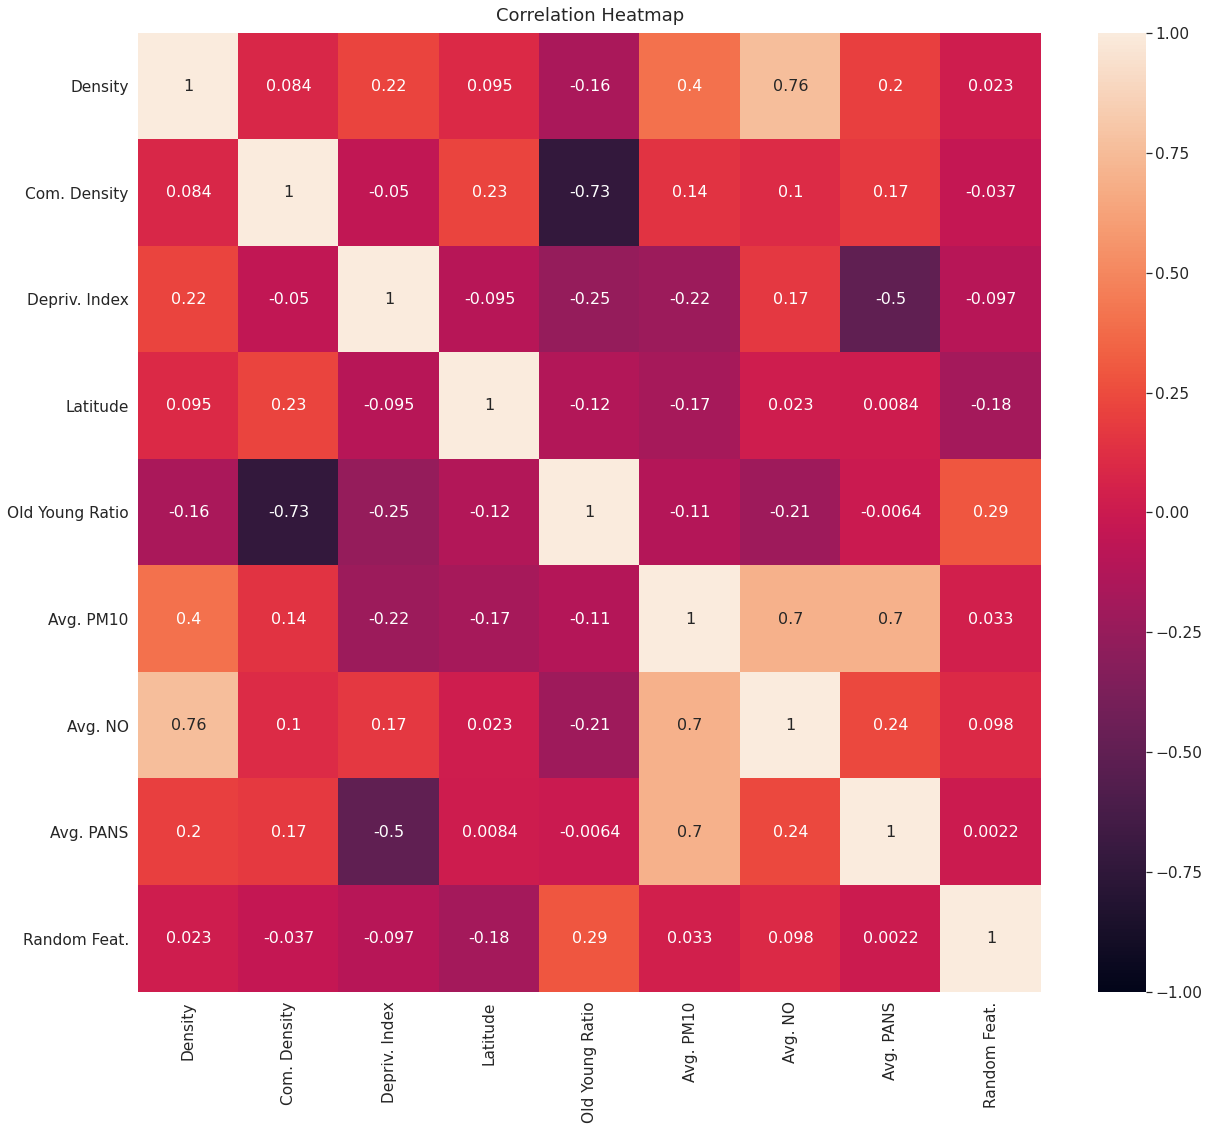

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38368  0.05246 
    Test set average RMSE:  1.05307  0.12749 

Prediction STD :    0.73983
True value STD :    1.04859
Difference in percentage:   29.44515

             Fullset RMSE:    0.34594
                       R2:    0.89116


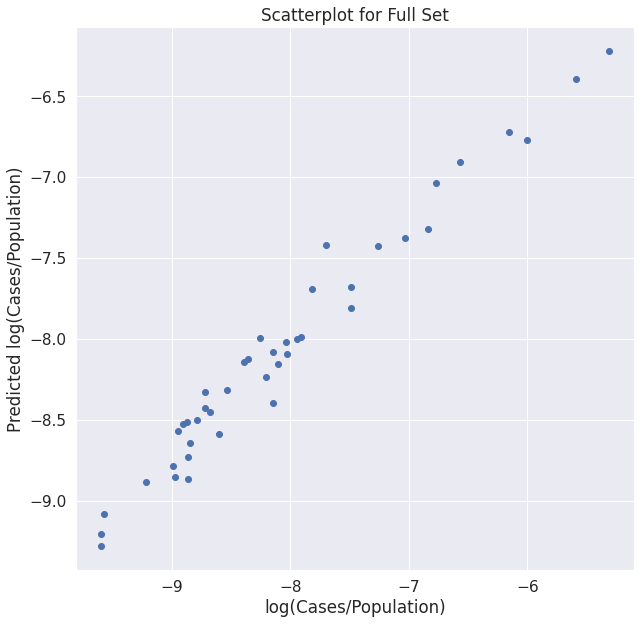

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                Old Young Ratio, Score: 0.17147 +/- 0.03336
Feature:                      Avg. PM10, Score: 0.22592 +/- 0.03862
Feature:                        Avg. NO, Score: 0.22157 +/- 0.04840


<Figure size 432x288 with 0 Axes>

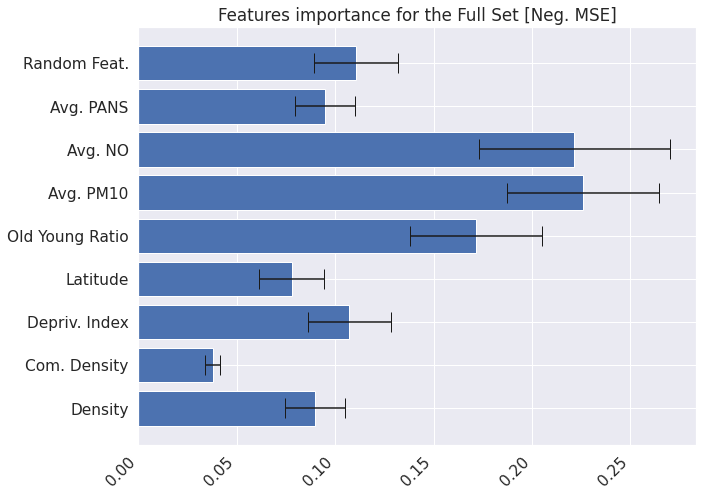

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                Old Young Ratio, Score: 0.15595 +/- 0.03034
Feature:                      Avg. PM10, Score: 0.20547 +/- 0.03513
Feature:                        Avg. NO, Score: 0.20151 +/- 0.04402


<Figure size 432x288 with 0 Axes>

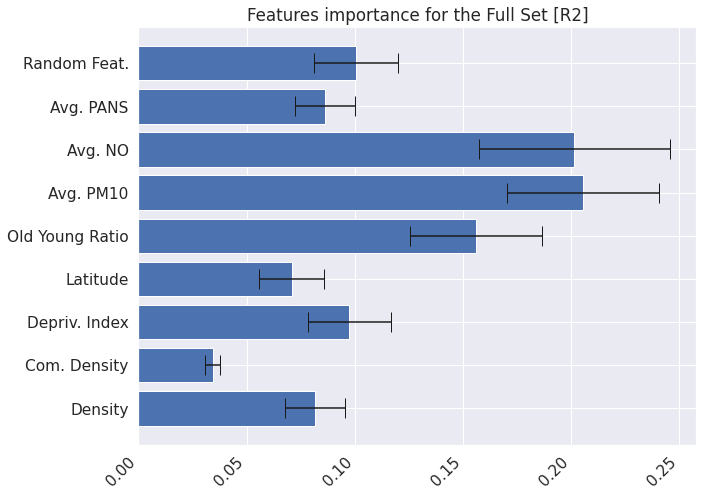

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35169
                       R2:    0.89194


<Figure size 432x288 with 0 Axes>

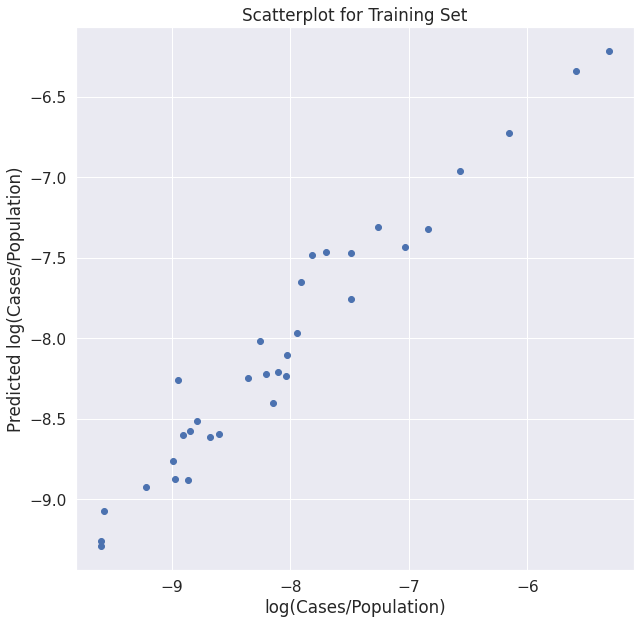

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.30499
                       R2:   -0.82791


<Figure size 432x288 with 0 Axes>

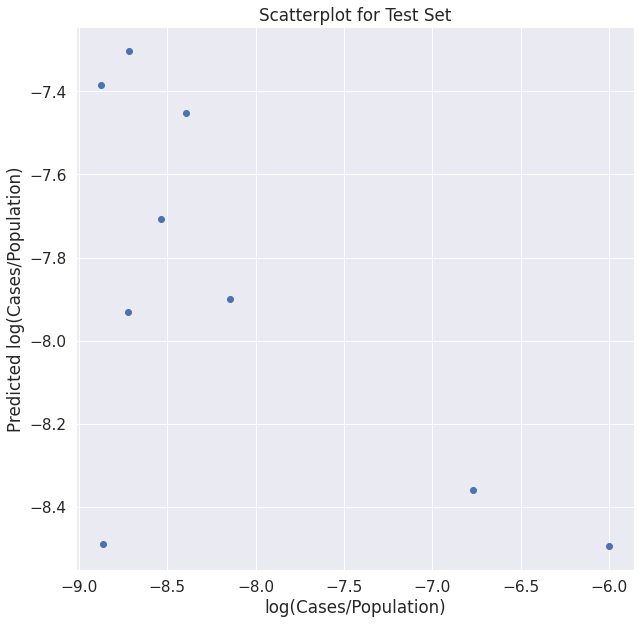

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                      Avg. PANS, Score: 0.06197 +/- 0.02928


<Figure size 432x288 with 0 Axes>

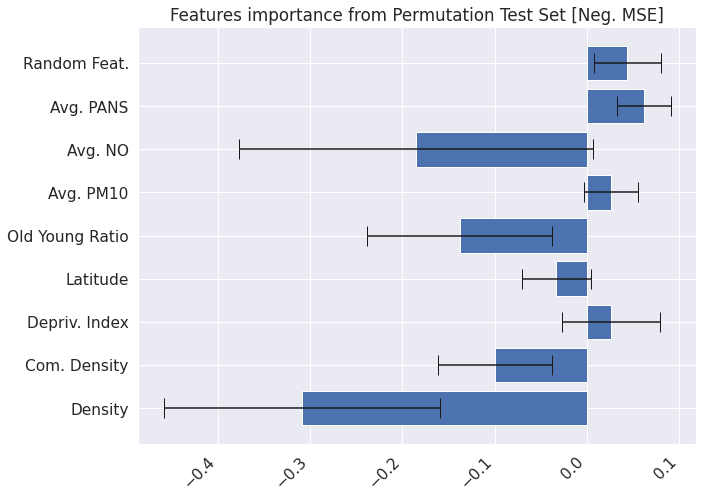

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                      Avg. PANS, Score: 0.06652 +/- 0.03143


<Figure size 432x288 with 0 Axes>

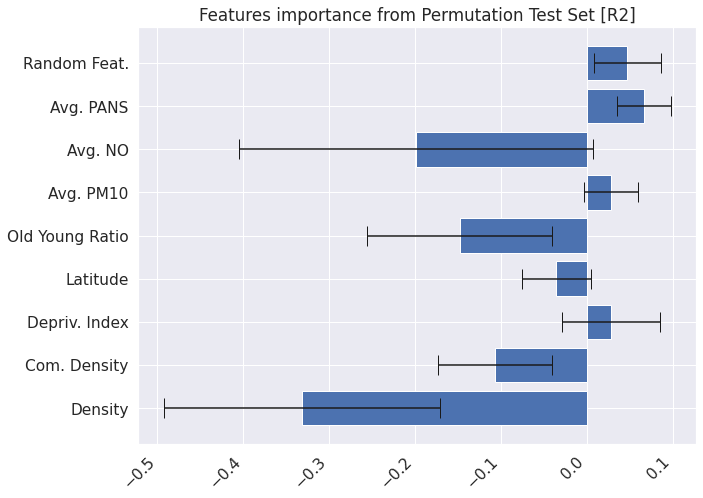

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.19569 +/- 0.04702
Feature:                  Depriv. Index, Score: 0.07112 +/- 0.01699
Feature:                Old Young Ratio, Score: 0.15571 +/- 0.03480
Feature:                      Avg. PM10, Score: 0.16239 +/- 0.02636
Feature:                        Avg. NO, Score: 0.23967 +/- 0.06481


<Figure size 432x288 with 0 Axes>

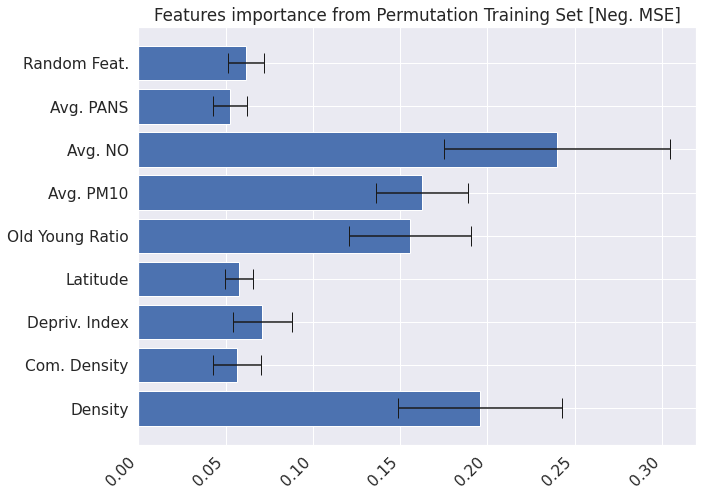

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.17097 +/- 0.04108
Feature:                  Depriv. Index, Score: 0.06213 +/- 0.01484
Feature:                Old Young Ratio, Score: 0.13604 +/- 0.03040
Feature:                      Avg. PM10, Score: 0.14187 +/- 0.02303
Feature:                        Avg. NO, Score: 0.20939 +/- 0.05662


<Figure size 432x288 with 0 Axes>

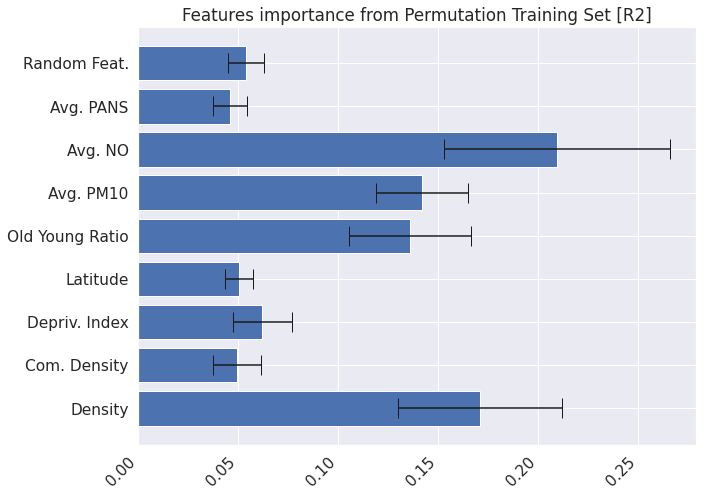

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38792  0.06000 
    Test set average RMSE:  1.01629  0.13898 

Prediction STD :    0.76310
True value STD :    1.04859
Difference in percentage:   27.22585

             Fullset RMSE:    0.33971
                       R2:    0.89505


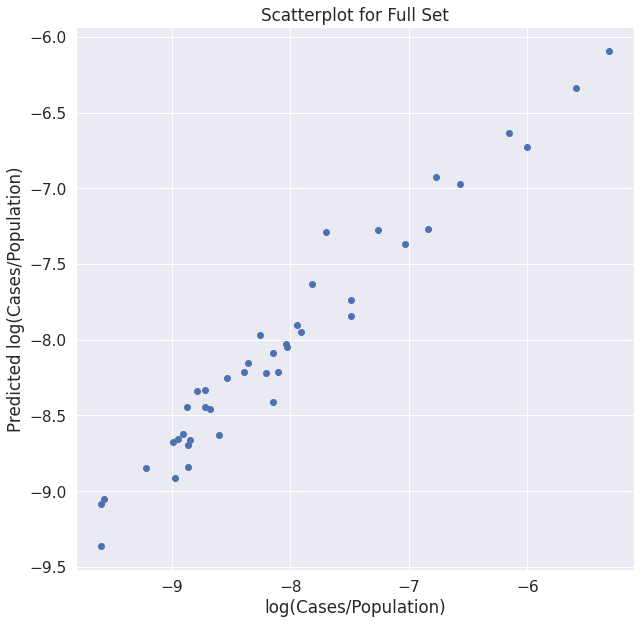

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.15548 +/- 0.03028
Feature:                Old Young Ratio, Score: 0.18892 +/- 0.03827
Feature:                      Avg. PM10, Score: 0.22102 +/- 0.03873
Feature:                        Avg. NO, Score: 0.26679 +/- 0.05914


<Figure size 432x288 with 0 Axes>

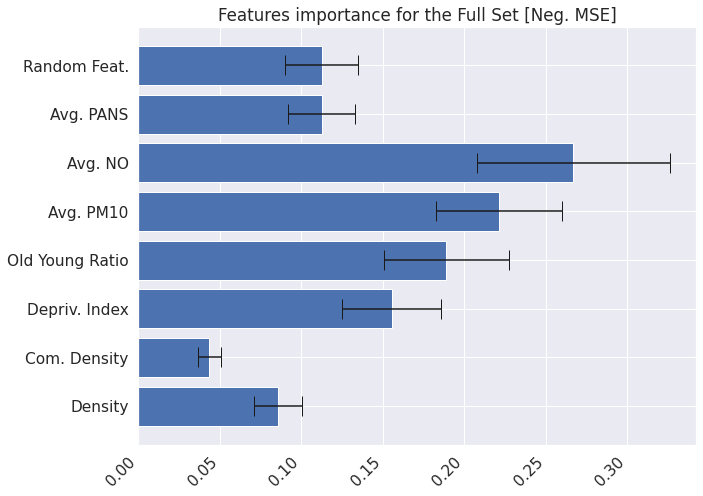

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.14141 +/- 0.02754
Feature:                Old Young Ratio, Score: 0.17181 +/- 0.03480
Feature:                      Avg. PM10, Score: 0.20101 +/- 0.03522
Feature:                        Avg. NO, Score: 0.24264 +/- 0.05379


<Figure size 432x288 with 0 Axes>

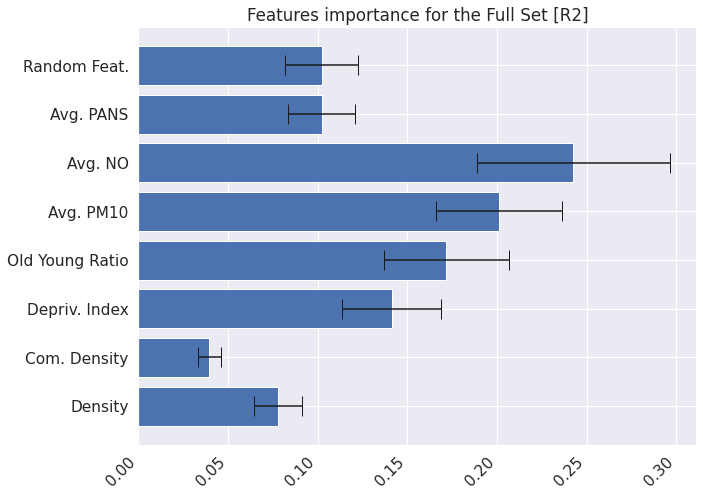

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.36039
                       R2:    0.88653


<Figure size 432x288 with 0 Axes>

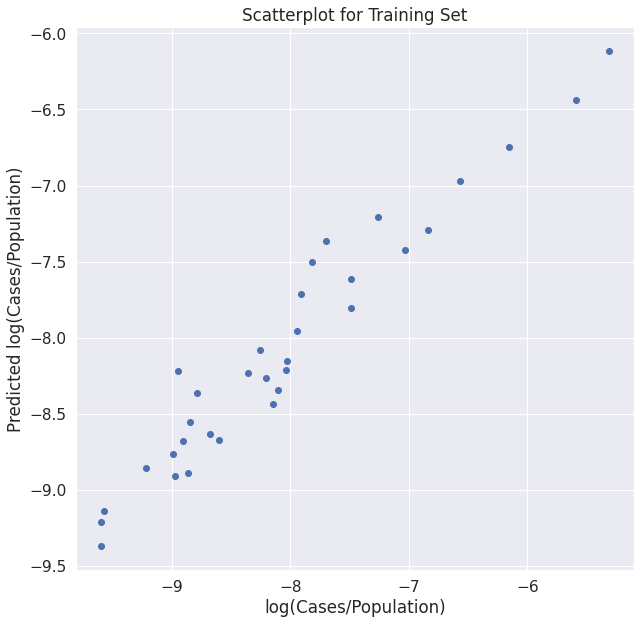

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.27998
                       R2:   -0.75852


<Figure size 432x288 with 0 Axes>

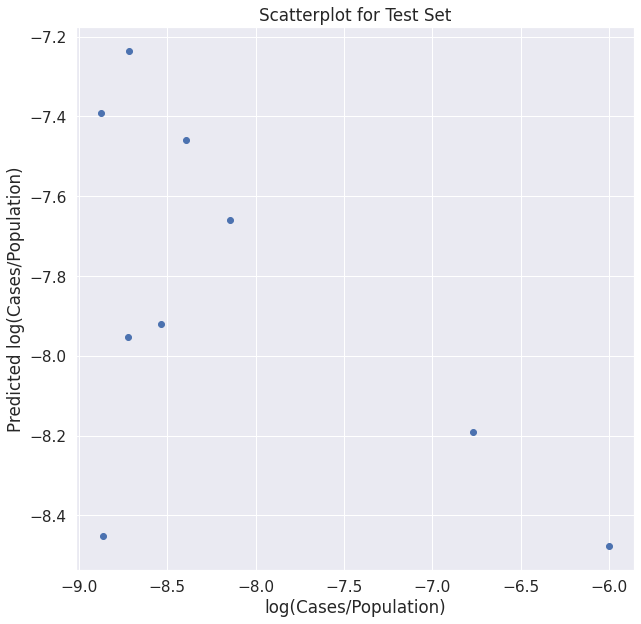

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.05637 +/- 0.06204


<Figure size 432x288 with 0 Axes>

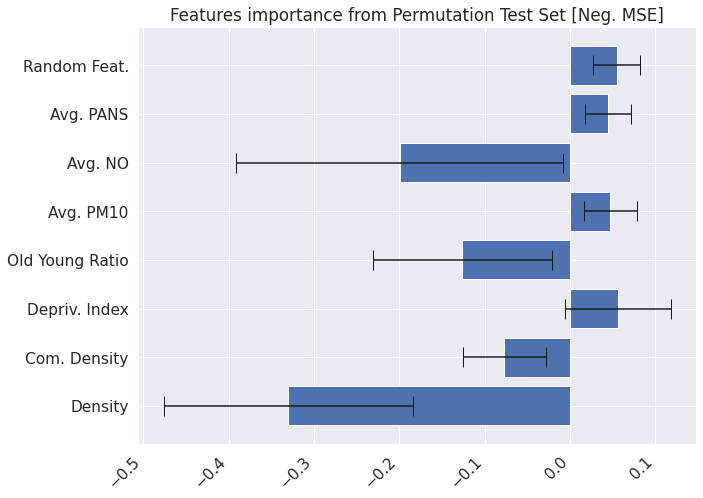

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.06050 +/- 0.06659


<Figure size 432x288 with 0 Axes>

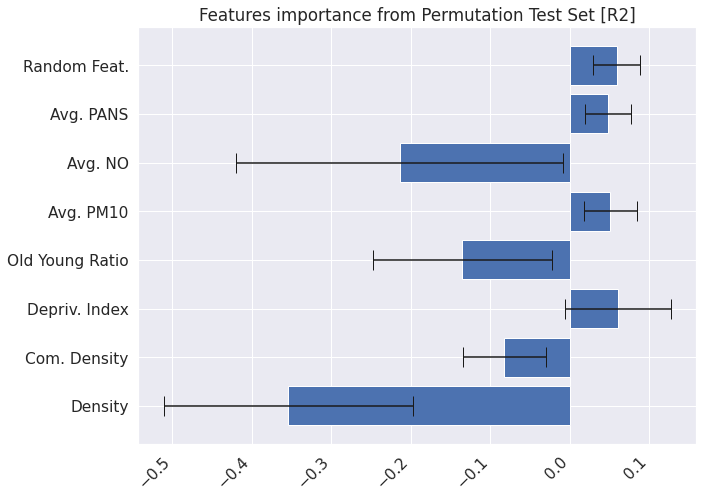

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.20892 +/- 0.04998
Feature:                  Depriv. Index, Score: 0.09048 +/- 0.02080
Feature:                Old Young Ratio, Score: 0.13759 +/- 0.03109
Feature:                      Avg. PM10, Score: 0.18829 +/- 0.02923
Feature:                        Avg. NO, Score: 0.26149 +/- 0.07543


<Figure size 432x288 with 0 Axes>

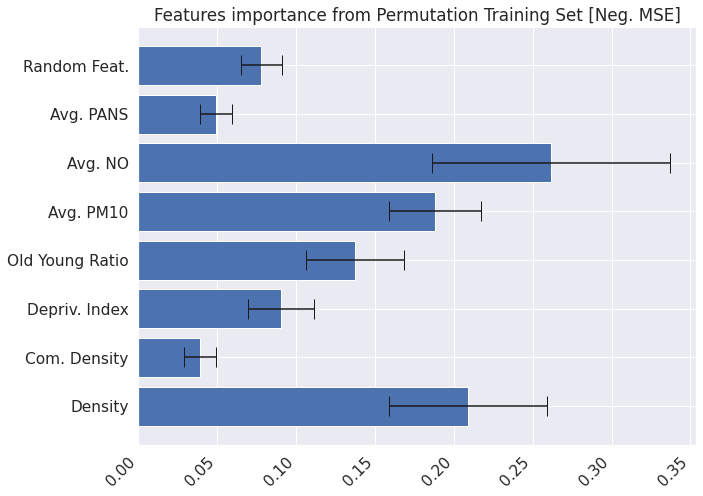

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.18253 +/- 0.04367
Feature:                  Depriv. Index, Score: 0.07905 +/- 0.01817
Feature:                Old Young Ratio, Score: 0.12020 +/- 0.02716
Feature:                      Avg. PM10, Score: 0.16450 +/- 0.02554
Feature:                        Avg. NO, Score: 0.22846 +/- 0.06590


<Figure size 432x288 with 0 Axes>

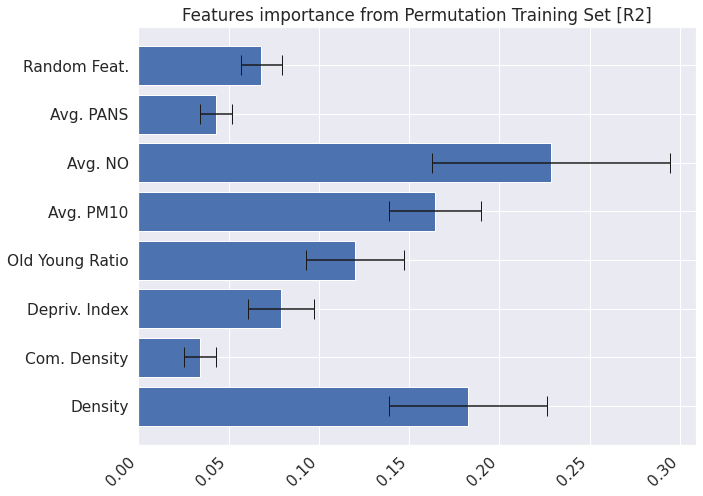

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36694  0.05108 
    Test set average RMSE:  1.06798  0.10385 

Prediction STD :    0.76745
True value STD :    1.04859
Difference in percentage:   26.81133

             Fullset RMSE:    0.33191
                       R2:    0.89981


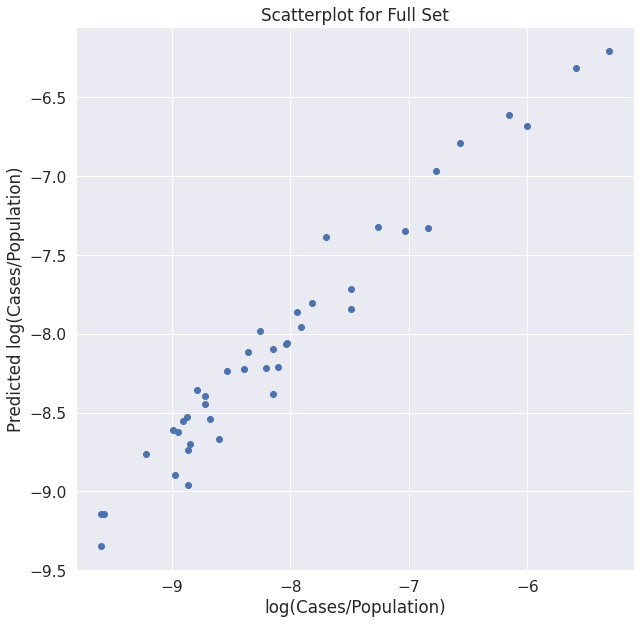

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.13830 +/- 0.02760
Feature:                Old Young Ratio, Score: 0.18530 +/- 0.03625
Feature:                      Avg. PM10, Score: 0.26500 +/- 0.04285
Feature:                        Avg. NO, Score: 0.24607 +/- 0.05102


<Figure size 432x288 with 0 Axes>

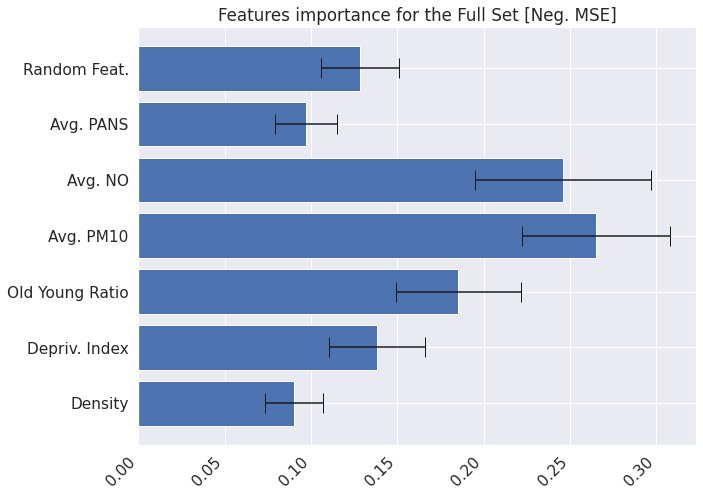

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.12578 +/- 0.02510
Feature:                Old Young Ratio, Score: 0.16852 +/- 0.03297
Feature:                      Avg. PM10, Score: 0.24101 +/- 0.03898
Feature:                        Avg. NO, Score: 0.22379 +/- 0.04640


<Figure size 432x288 with 0 Axes>

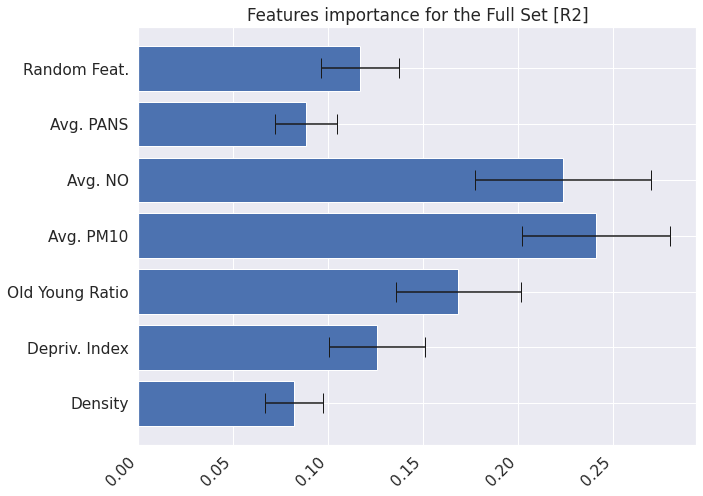

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.36820
                       R2:    0.88156


<Figure size 432x288 with 0 Axes>

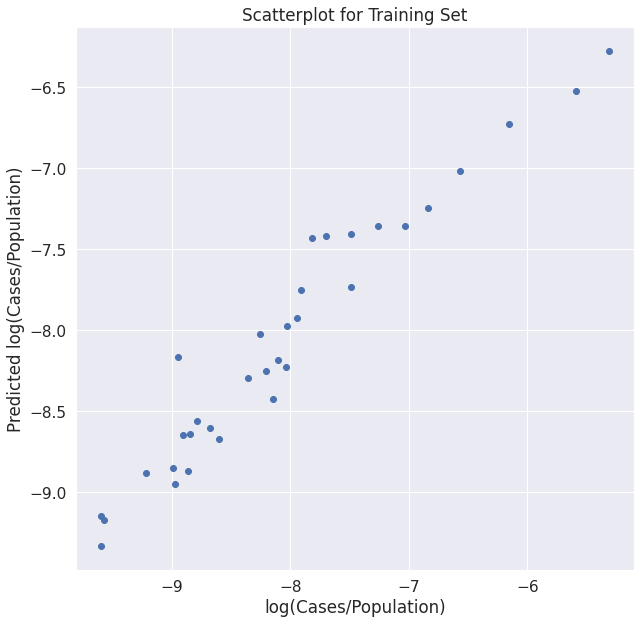

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.33169
                       R2:   -0.90347


<Figure size 432x288 with 0 Axes>

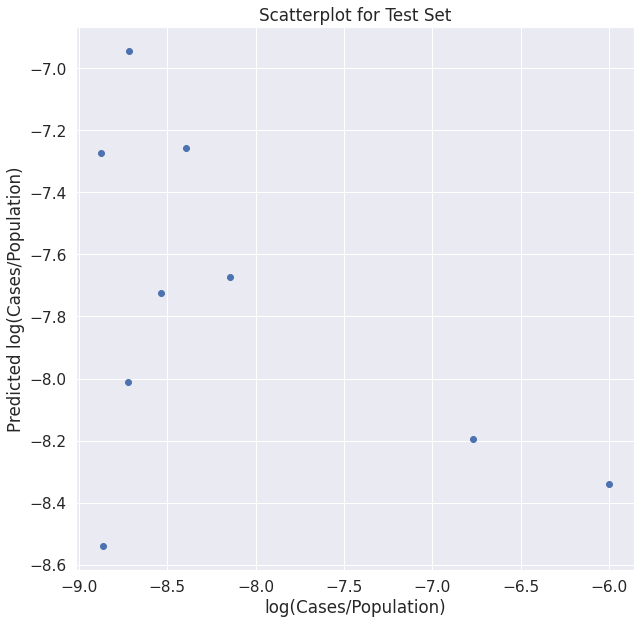

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.04563 +/- 0.11540
Feature:                      Avg. PANS, Score: 0.04168 +/- 0.03300


<Figure size 432x288 with 0 Axes>

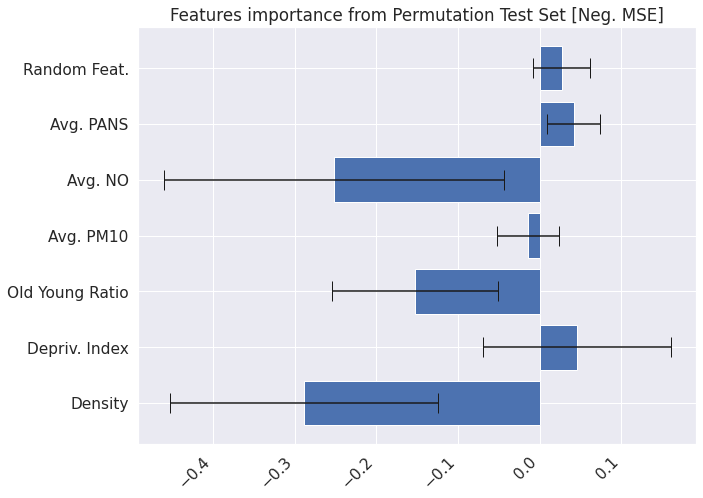

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.04897 +/- 0.12386
Feature:                      Avg. PANS, Score: 0.04474 +/- 0.03542


<Figure size 432x288 with 0 Axes>

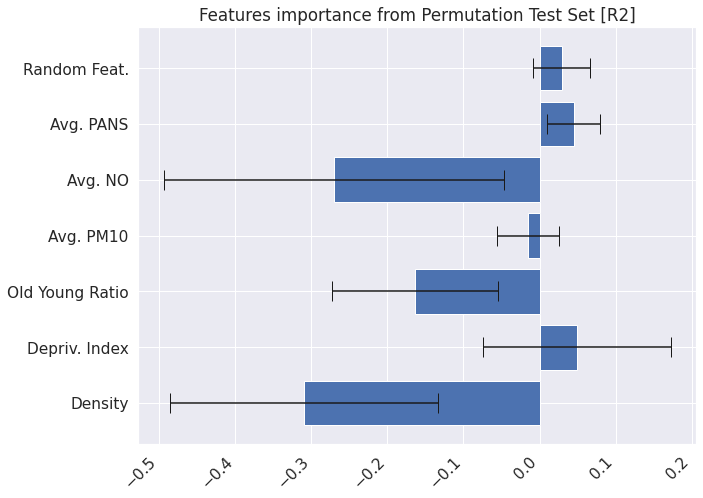

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.18904 +/- 0.04435
Feature:                  Depriv. Index, Score: 0.11145 +/- 0.02611
Feature:                Old Young Ratio, Score: 0.21088 +/- 0.04363
Feature:                      Avg. PM10, Score: 0.17866 +/- 0.03015
Feature:                        Avg. NO, Score: 0.26969 +/- 0.07099


<Figure size 432x288 with 0 Axes>

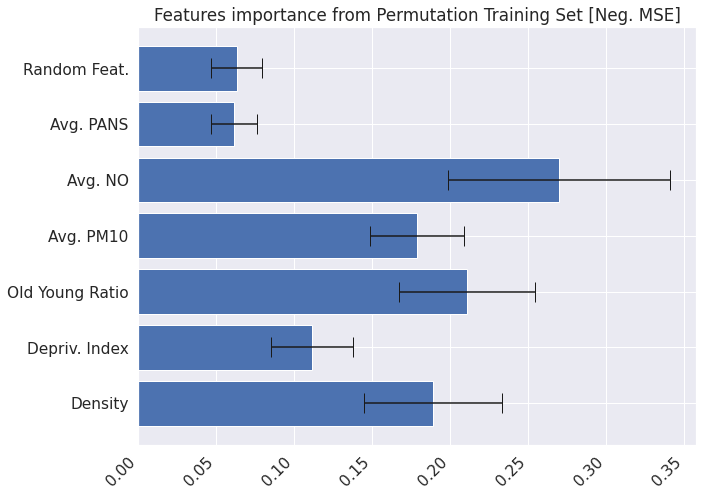

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.16516 +/- 0.03875
Feature:                  Depriv. Index, Score: 0.09737 +/- 0.02282
Feature:                Old Young Ratio, Score: 0.18423 +/- 0.03811
Feature:                      Avg. PM10, Score: 0.15609 +/- 0.02634
Feature:                        Avg. NO, Score: 0.23562 +/- 0.06202


<Figure size 432x288 with 0 Axes>

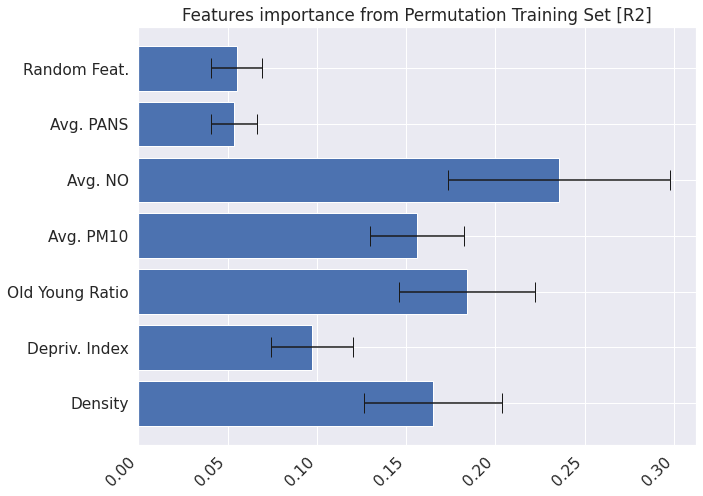

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38820  0.06117 
    Test set average RMSE:  1.07237  0.12223 

Prediction STD :    0.70790
True value STD :    1.04859
Difference in percentage:   32.49038

             Fullset RMSE:    0.40982
                       R2:    0.84725


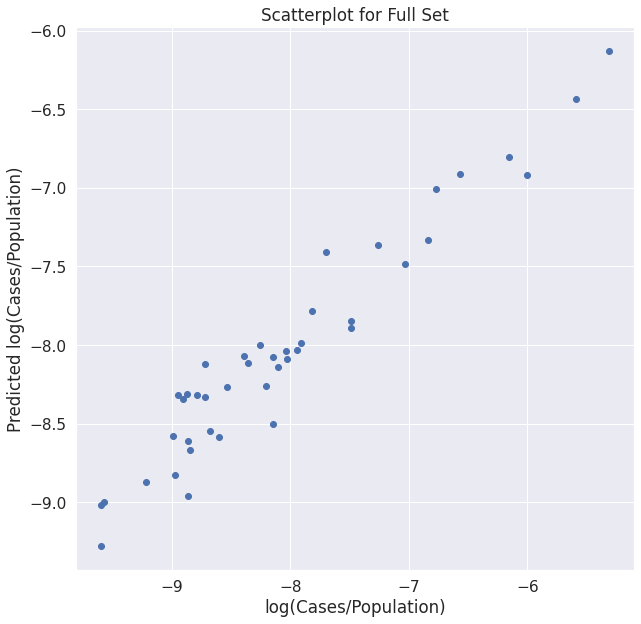

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                Old Young Ratio, Score: 0.15941 +/- 0.03483
Feature:                      Avg. PM10, Score: 0.21520 +/- 0.03761
Feature:                        Avg. NO, Score: 0.21099 +/- 0.04541


<Figure size 432x288 with 0 Axes>

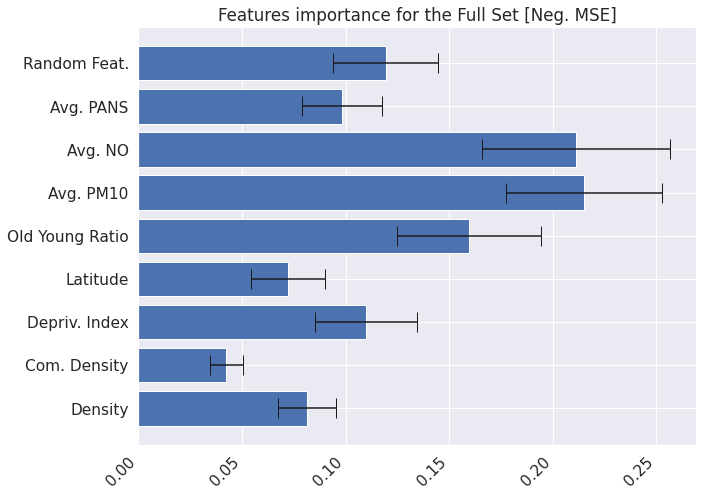

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                Old Young Ratio, Score: 0.14498 +/- 0.03167
Feature:                      Avg. PM10, Score: 0.19572 +/- 0.03421
Feature:                        Avg. NO, Score: 0.19190 +/- 0.04130


<Figure size 432x288 with 0 Axes>

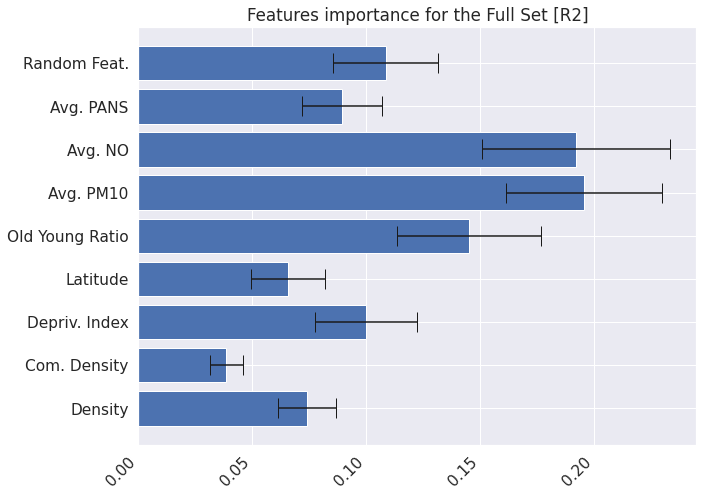

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.41034
                       R2:    0.85289


<Figure size 432x288 with 0 Axes>

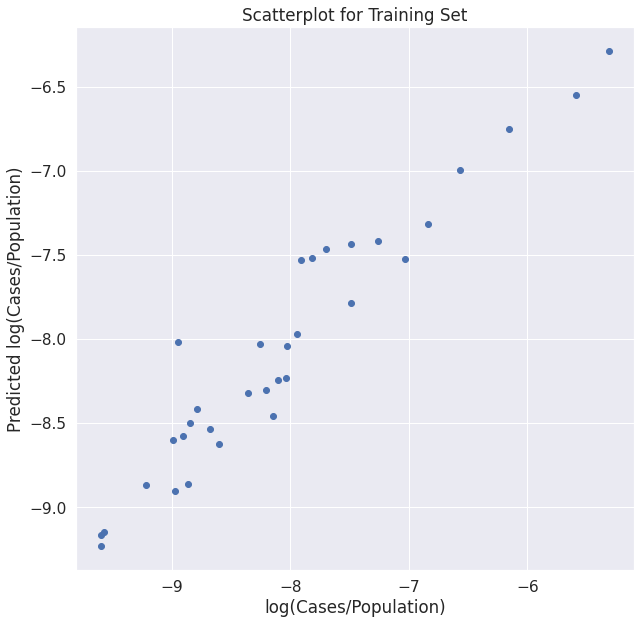

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.34785
                       R2:   -0.94994


<Figure size 432x288 with 0 Axes>

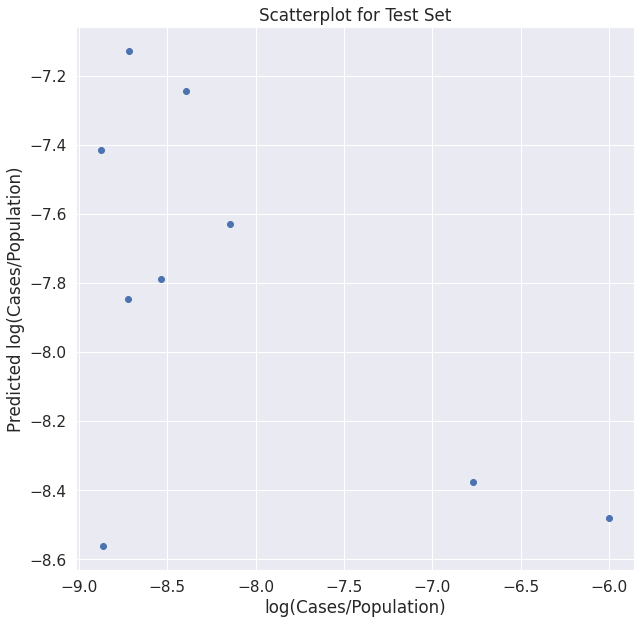

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 


<Figure size 432x288 with 0 Axes>

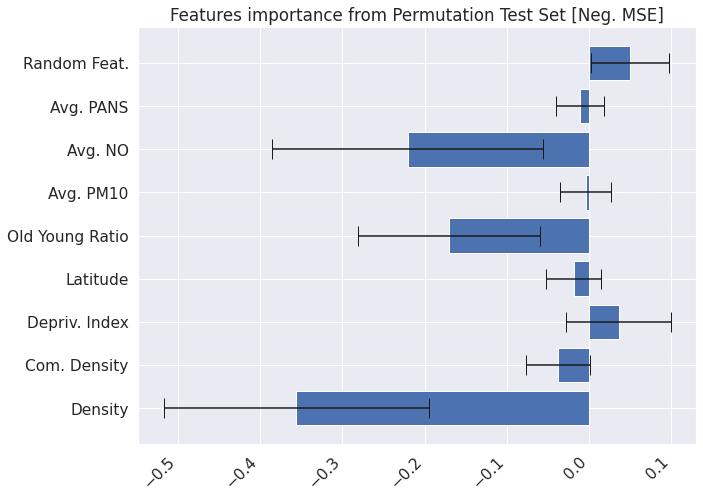

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 


<Figure size 432x288 with 0 Axes>

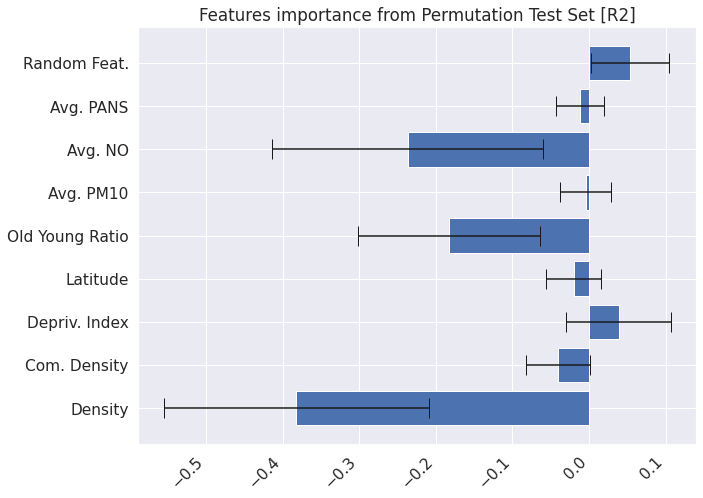

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.19111 +/- 0.04832
Feature:                Old Young Ratio, Score: 0.17767 +/- 0.04179
Feature:                      Avg. PM10, Score: 0.16369 +/- 0.02657
Feature:                        Avg. NO, Score: 0.21985 +/- 0.06579


<Figure size 432x288 with 0 Axes>

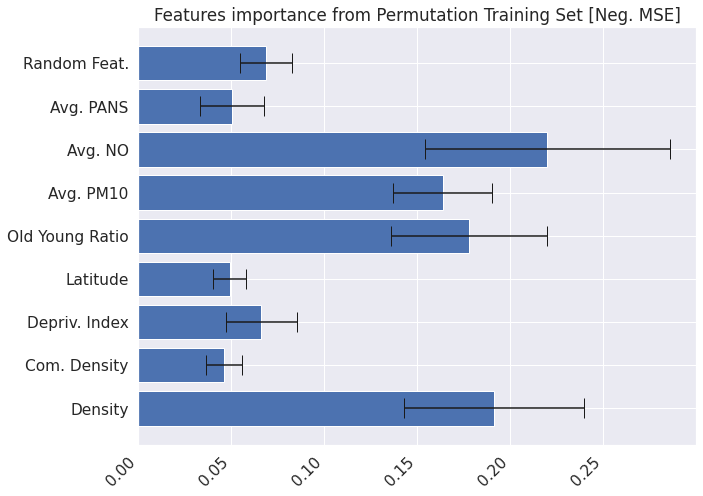

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.16696 +/- 0.04222
Feature:                Old Young Ratio, Score: 0.15523 +/- 0.03651
Feature:                      Avg. PM10, Score: 0.14301 +/- 0.02321
Feature:                        Avg. NO, Score: 0.19207 +/- 0.05748


<Figure size 432x288 with 0 Axes>

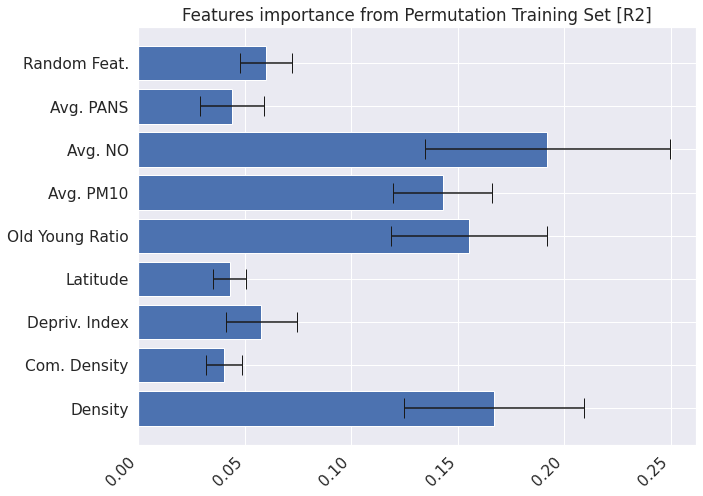

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38094  0.04764 
    Test set average RMSE:  1.04145  0.11592 

Prediction STD :    0.74175
True value STD :    1.04859
Difference in percentage:   29.26146

             Fullset RMSE:    0.34473
                       R2:    0.89192


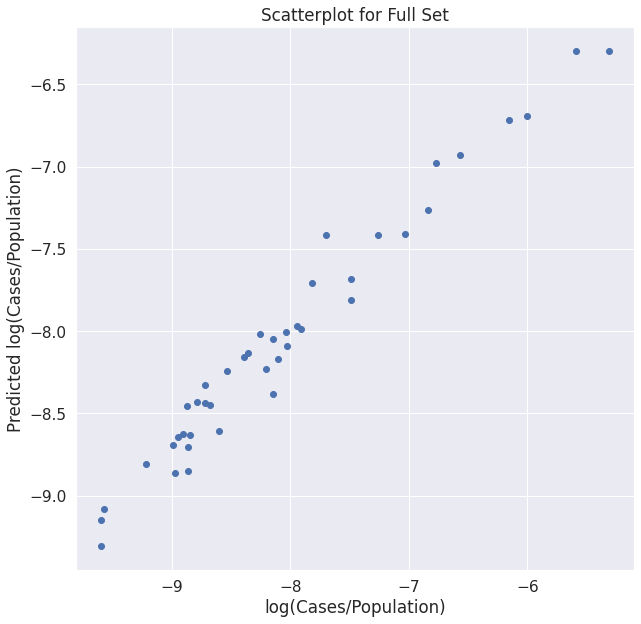

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.14797 +/- 0.02616
Feature:                Old Young Ratio, Score: 0.17693 +/- 0.03267
Feature:                      Avg. PM10, Score: 0.22869 +/- 0.03633
Feature:                        Avg. NO, Score: 0.22215 +/- 0.04988


<Figure size 432x288 with 0 Axes>

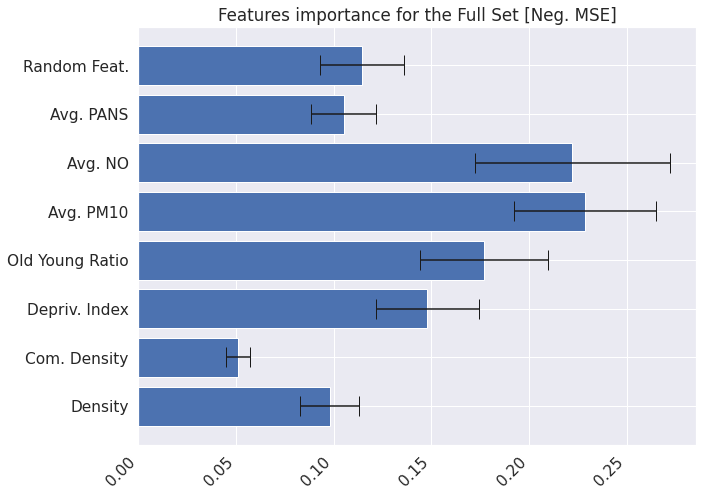

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.13458 +/- 0.02380
Feature:                Old Young Ratio, Score: 0.16091 +/- 0.02972
Feature:                      Avg. PM10, Score: 0.20799 +/- 0.03304
Feature:                        Avg. NO, Score: 0.20204 +/- 0.04536


<Figure size 432x288 with 0 Axes>

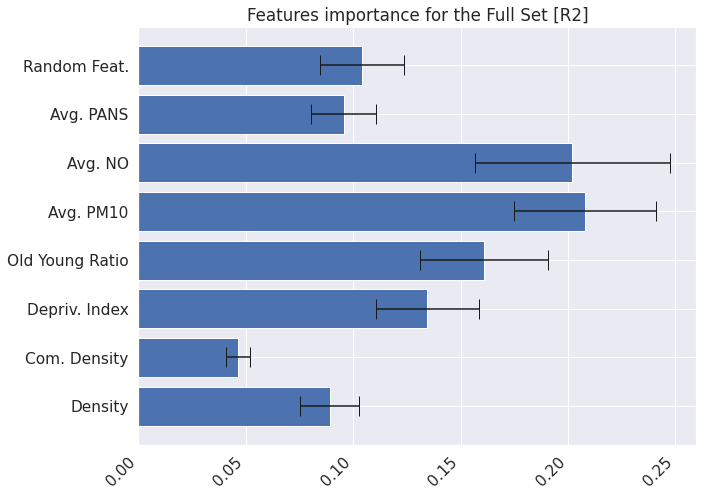

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35401
                       R2:    0.89051


<Figure size 432x288 with 0 Axes>

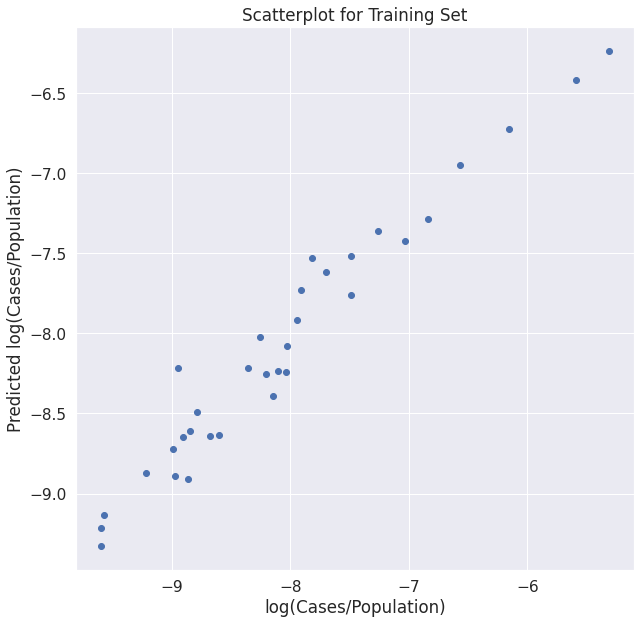

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.32043
                       R2:   -0.87141


<Figure size 432x288 with 0 Axes>

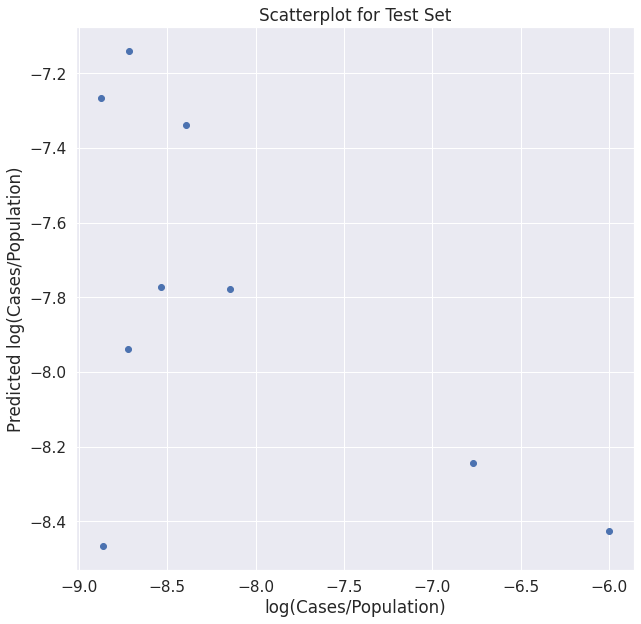

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.05026 +/- 0.07343
Feature:                      Avg. PANS, Score: 0.03689 +/- 0.02661


<Figure size 432x288 with 0 Axes>

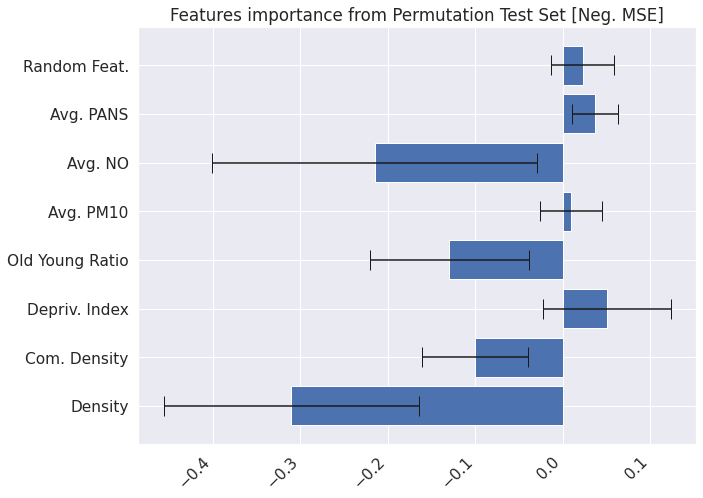

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.05395 +/- 0.07882
Feature:                      Avg. PANS, Score: 0.03959 +/- 0.02856


<Figure size 432x288 with 0 Axes>

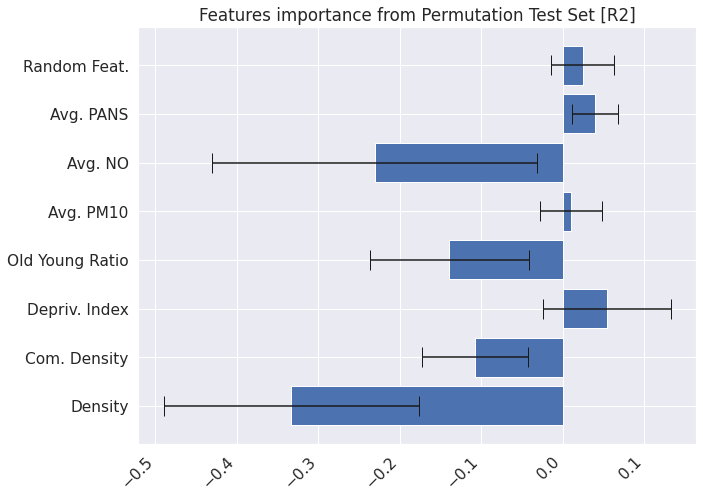

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.19393 +/- 0.04671
Feature:                  Depriv. Index, Score: 0.10354 +/- 0.02364
Feature:                Old Young Ratio, Score: 0.16005 +/- 0.03478
Feature:                      Avg. PM10, Score: 0.16347 +/- 0.02681
Feature:                        Avg. NO, Score: 0.23304 +/- 0.06198


<Figure size 432x288 with 0 Axes>

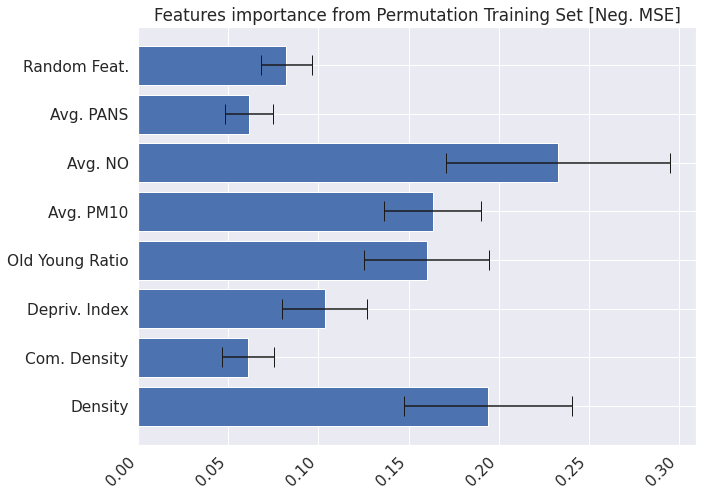

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.16943 +/- 0.04081
Feature:                  Depriv. Index, Score: 0.09046 +/- 0.02065
Feature:                Old Young Ratio, Score: 0.13983 +/- 0.03039
Feature:                      Avg. PM10, Score: 0.14282 +/- 0.02342
Feature:                        Avg. NO, Score: 0.20360 +/- 0.05415


<Figure size 432x288 with 0 Axes>

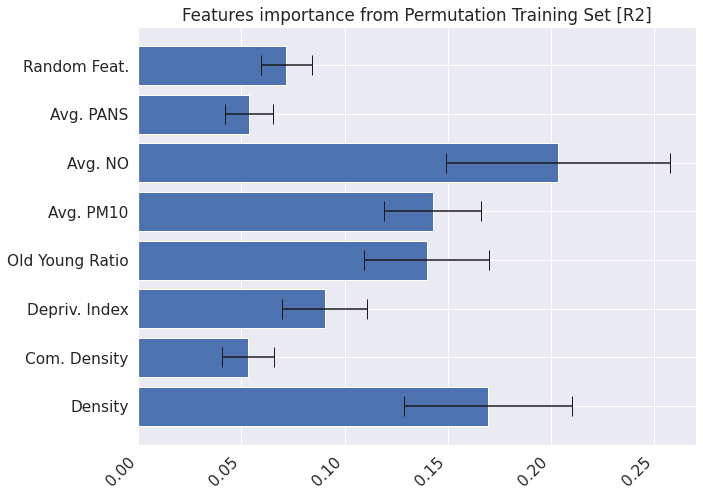

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37178  0.05096 
    Test set average RMSE:  1.04571  0.13090 

Prediction STD :    0.75198
True value STD :    1.04859
Difference in percentage:   28.28604

             Fullset RMSE:    0.33742
                       R2:    0.89645


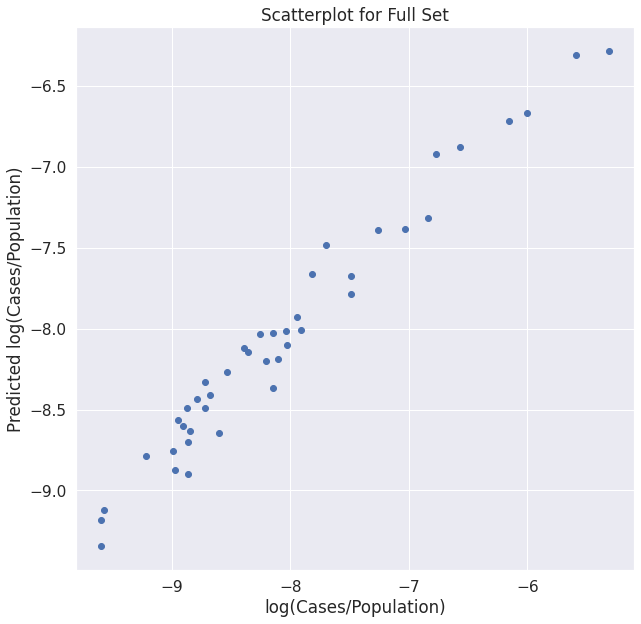

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.14460 +/- 0.02598
Feature:                Old Young Ratio, Score: 0.17913 +/- 0.03296
Feature:                      Avg. PM10, Score: 0.23631 +/- 0.03682
Feature:                        Avg. NO, Score: 0.25228 +/- 0.05270


<Figure size 432x288 with 0 Axes>

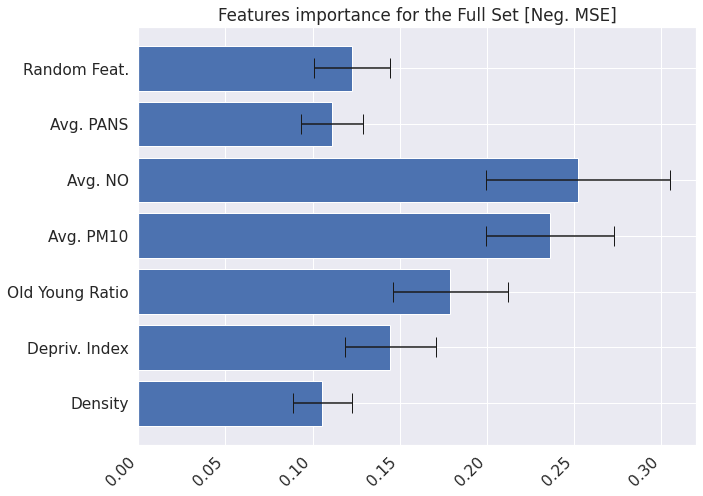

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.13151 +/- 0.02363
Feature:                Old Young Ratio, Score: 0.16292 +/- 0.02998
Feature:                      Avg. PM10, Score: 0.21491 +/- 0.03349
Feature:                        Avg. NO, Score: 0.22944 +/- 0.04793


<Figure size 432x288 with 0 Axes>

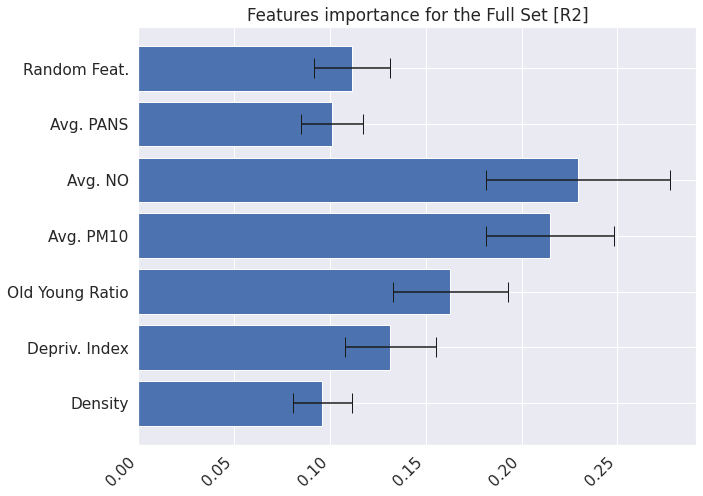

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35863
                       R2:    0.88763


<Figure size 432x288 with 0 Axes>

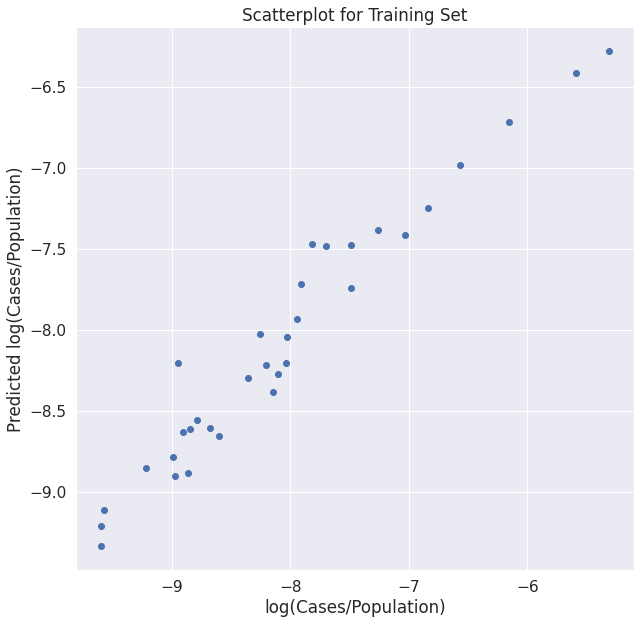

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.28081
                       R2:   -0.76081


<Figure size 432x288 with 0 Axes>

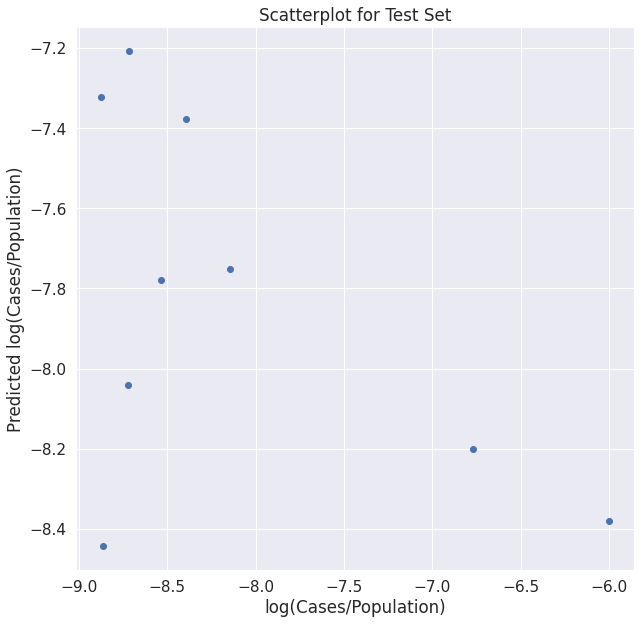

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 


<Figure size 432x288 with 0 Axes>

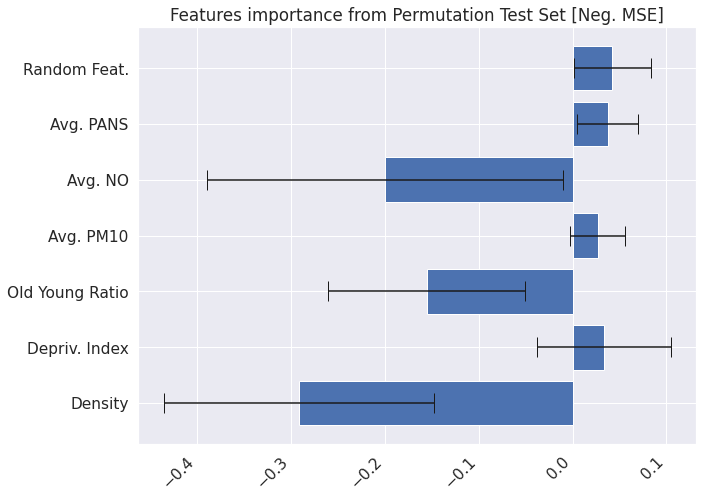

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 


<Figure size 432x288 with 0 Axes>

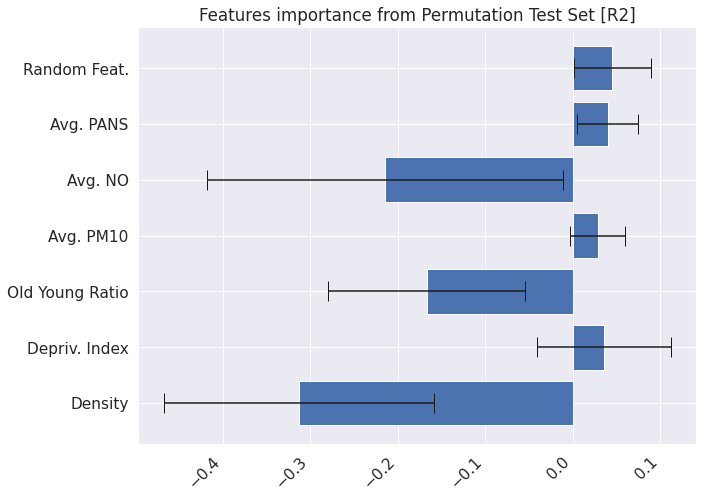

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.20023 +/- 0.04754
Feature:                  Depriv. Index, Score: 0.10596 +/- 0.02459
Feature:                Old Young Ratio, Score: 0.19438 +/- 0.04149
Feature:                      Avg. PM10, Score: 0.18796 +/- 0.02769
Feature:                        Avg. NO, Score: 0.26166 +/- 0.06731


<Figure size 432x288 with 0 Axes>

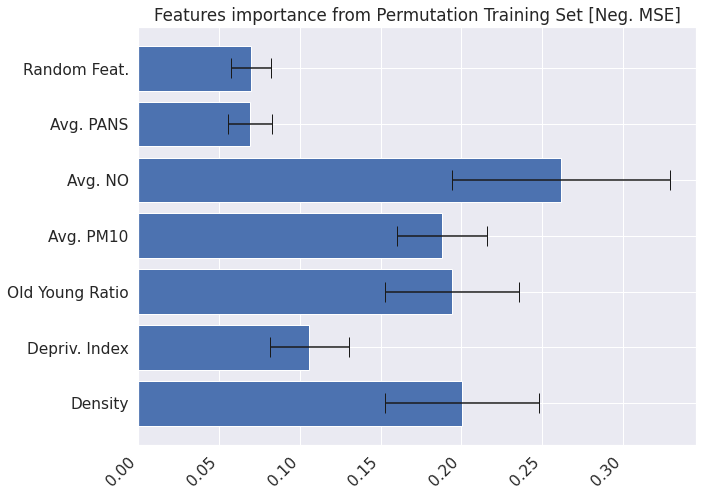

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.17494 +/- 0.04154
Feature:                  Depriv. Index, Score: 0.09257 +/- 0.02149
Feature:                Old Young Ratio, Score: 0.16982 +/- 0.03625
Feature:                      Avg. PM10, Score: 0.16422 +/- 0.02419
Feature:                        Avg. NO, Score: 0.22860 +/- 0.05880


<Figure size 432x288 with 0 Axes>

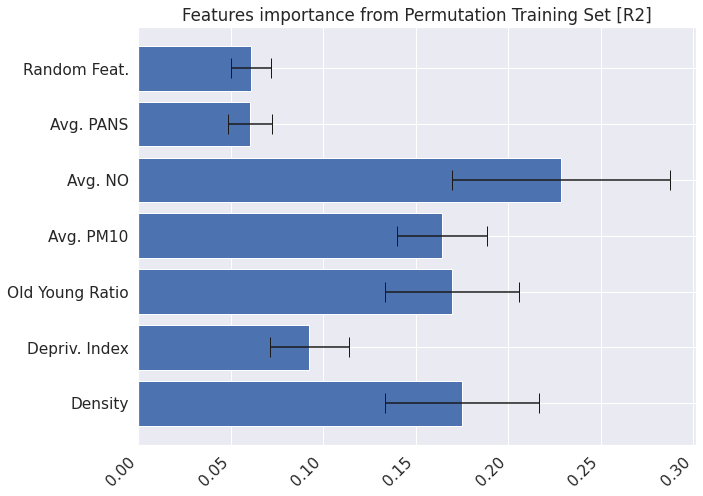

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.92798  0.11591 
    Test set average RMSE:  1.05745  0.13029 

Prediction STD :    0.50866
True value STD :    1.04859
Difference in percentage:   51.49132

             Fullset RMSE:    0.70221
                       R2:    0.55154


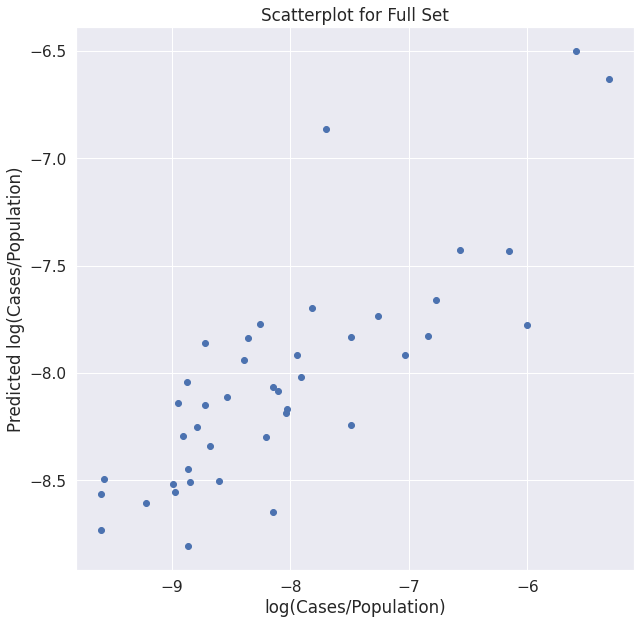

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                Old Young Ratio, Score: 0.14742 +/- 0.04122
Feature:                      Avg. PM10, Score: 0.36045 +/- 0.10036
Feature:                        Avg. NO, Score: 0.09639 +/- 0.03279


<Figure size 432x288 with 0 Axes>

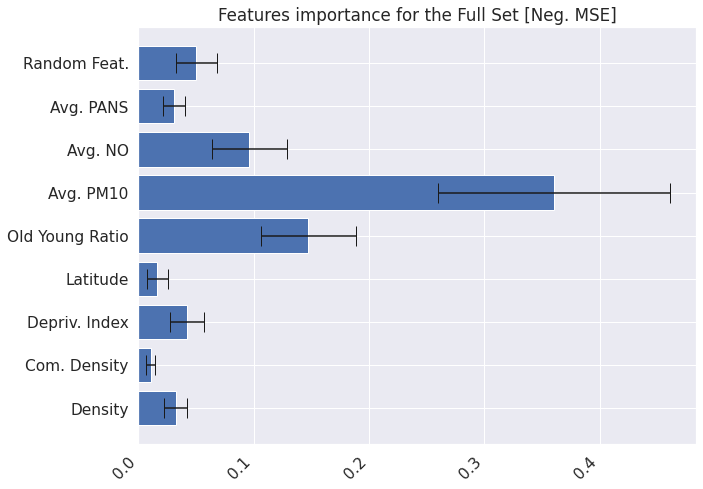

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                Old Young Ratio, Score: 0.13407 +/- 0.03749
Feature:                      Avg. PM10, Score: 0.32782 +/- 0.09127
Feature:                        Avg. NO, Score: 0.08767 +/- 0.02982


<Figure size 432x288 with 0 Axes>

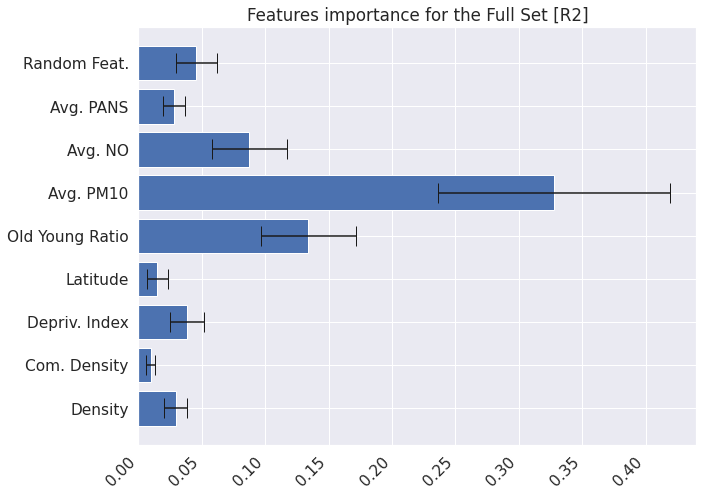

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.69594
                       R2:    0.57686


<Figure size 432x288 with 0 Axes>

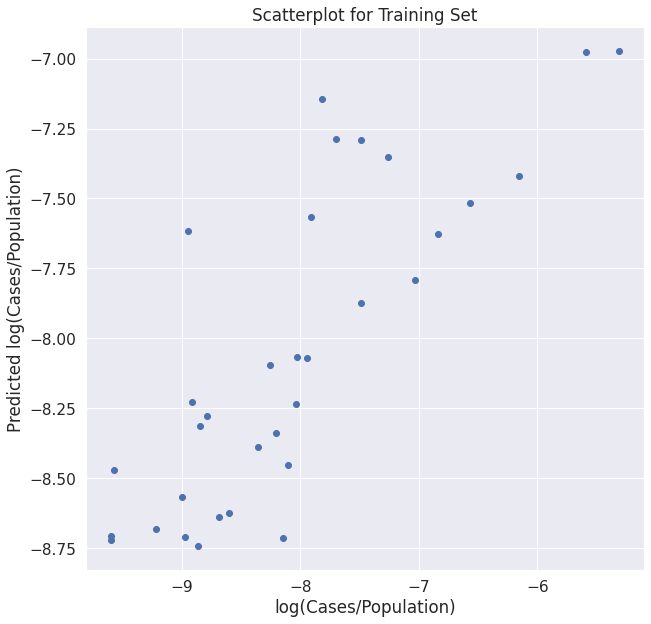

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.38511
                       R2:   -1.05924


<Figure size 432x288 with 0 Axes>

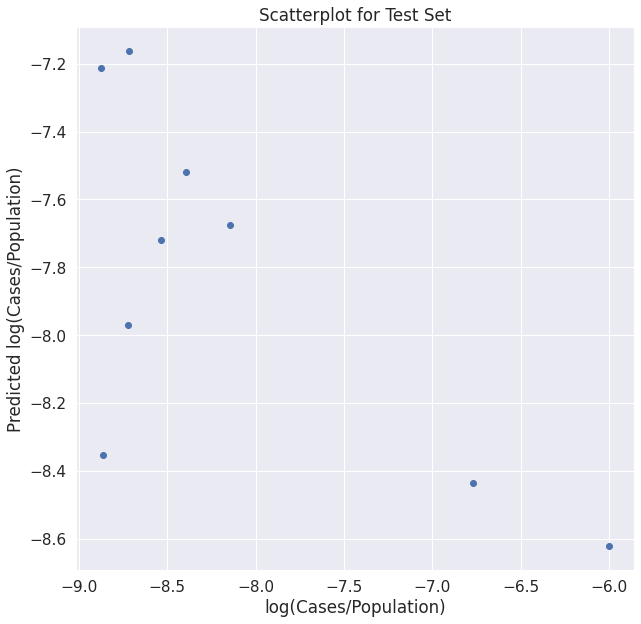

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.01693 +/- 0.01741


<Figure size 432x288 with 0 Axes>

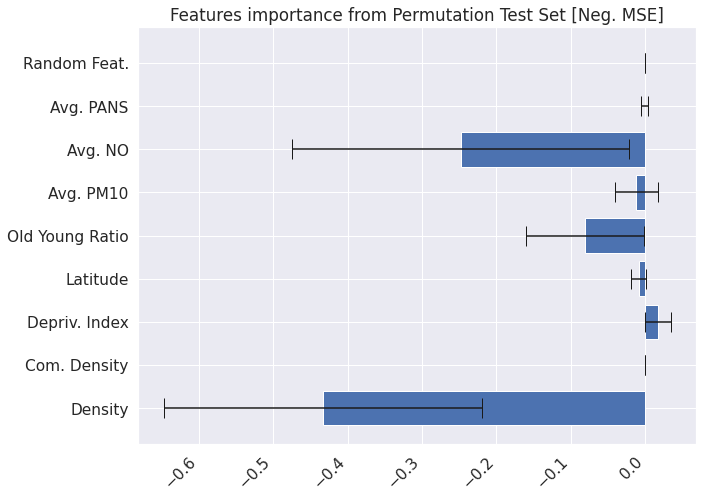

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.01817 +/- 0.01868


<Figure size 432x288 with 0 Axes>

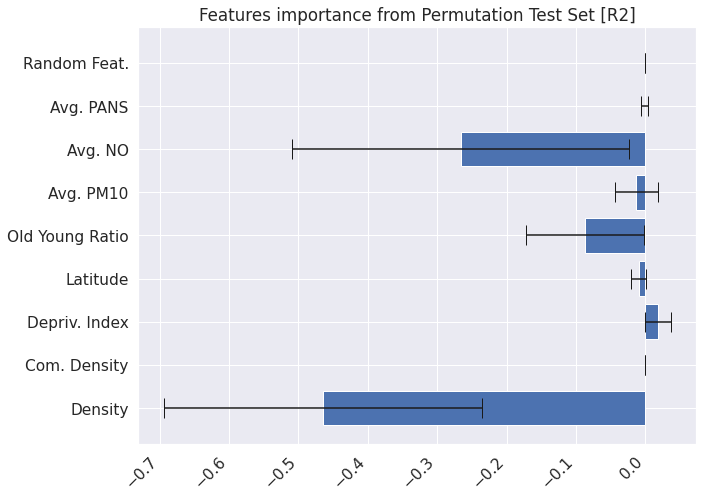

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.24230 +/- 0.06475
Feature:                  Depriv. Index, Score: 0.01491 +/- 0.00722
Feature:                       Latitude, Score: 0.00607 +/- 0.00255
Feature:                Old Young Ratio, Score: 0.06999 +/- 0.02323
Feature:                      Avg. PM10, Score: 0.14165 +/- 0.03810
Feature:                        Avg. NO, Score: 0.21929 +/- 0.07640
Feature:                      Avg. PANS, Score: 0.00414 +/- 0.00245


<Figure size 432x288 with 0 Axes>

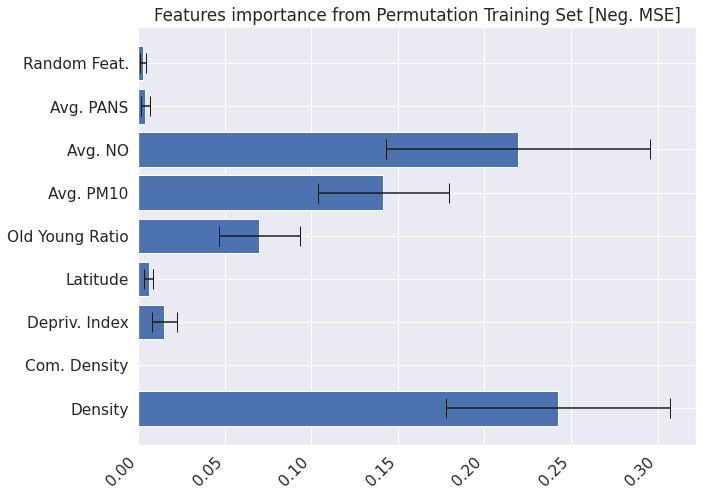

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.21169 +/- 0.05657
Feature:                  Depriv. Index, Score: 0.01303 +/- 0.00631
Feature:                       Latitude, Score: 0.00530 +/- 0.00223
Feature:                Old Young Ratio, Score: 0.06115 +/- 0.02030
Feature:                      Avg. PM10, Score: 0.12376 +/- 0.03329
Feature:                        Avg. NO, Score: 0.19159 +/- 0.06675
Feature:                      Avg. PANS, Score: 0.00362 +/- 0.00214


<Figure size 432x288 with 0 Axes>

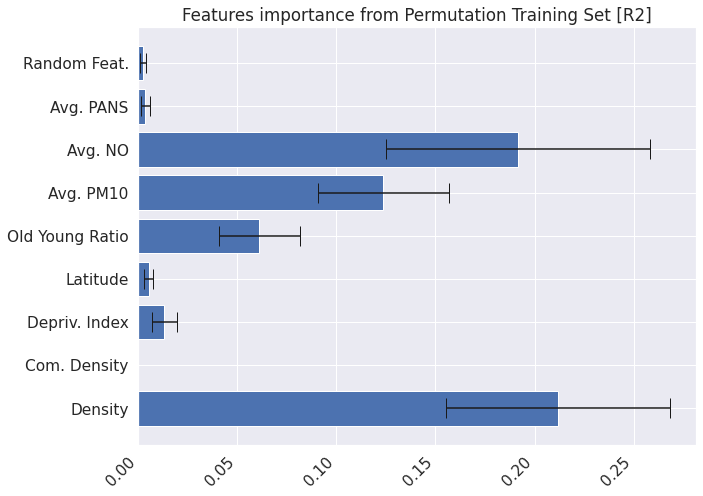

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.84753  0.12931 
    Test set average RMSE:  1.09207  0.12833 

Prediction STD :    0.35788
True value STD :    1.04859
Difference in percentage:   65.87032

             Fullset RMSE:    0.80194
                       R2:    0.41511


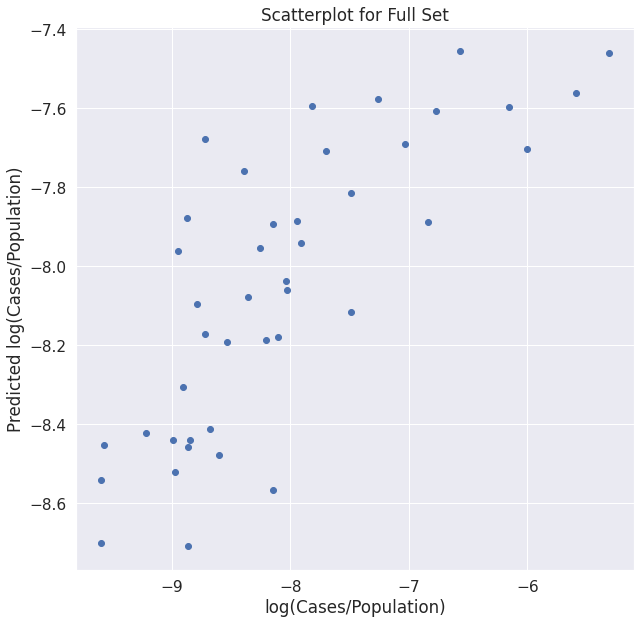

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04322 +/- 0.01033
Feature:                  Depriv. Index, Score: 0.08849 +/- 0.02768
Feature:                Old Young Ratio, Score: 0.08281 +/- 0.02610
Feature:                      Avg. PM10, Score: 0.10222 +/- 0.02377
Feature:                        Avg. NO, Score: 0.12573 +/- 0.04458


<Figure size 432x288 with 0 Axes>

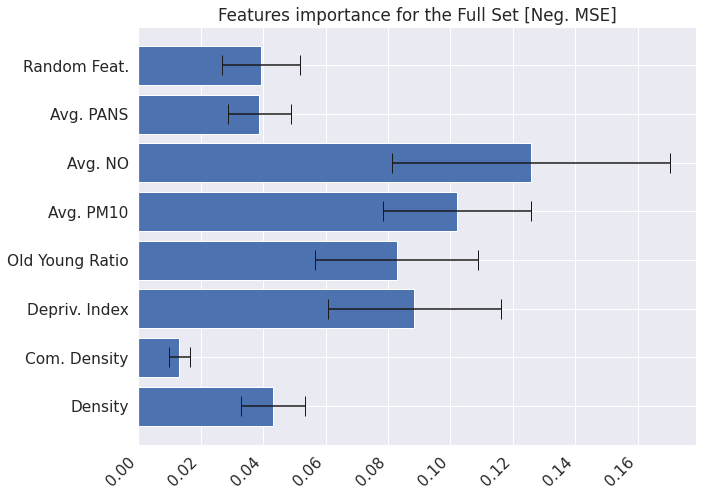

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03930 +/- 0.00939
Feature:                  Depriv. Index, Score: 0.08048 +/- 0.02517
Feature:                Old Young Ratio, Score: 0.07531 +/- 0.02374
Feature:                      Avg. PM10, Score: 0.09297 +/- 0.02162
Feature:                        Avg. NO, Score: 0.11435 +/- 0.04054


<Figure size 432x288 with 0 Axes>

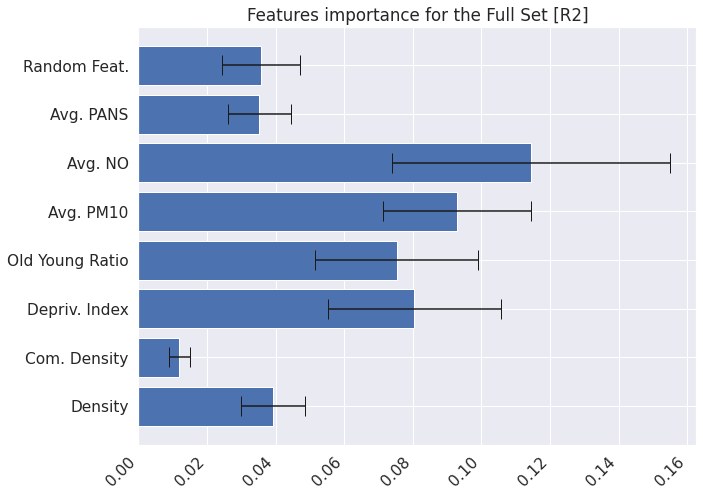

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.77173
                       R2:    0.47968


<Figure size 432x288 with 0 Axes>

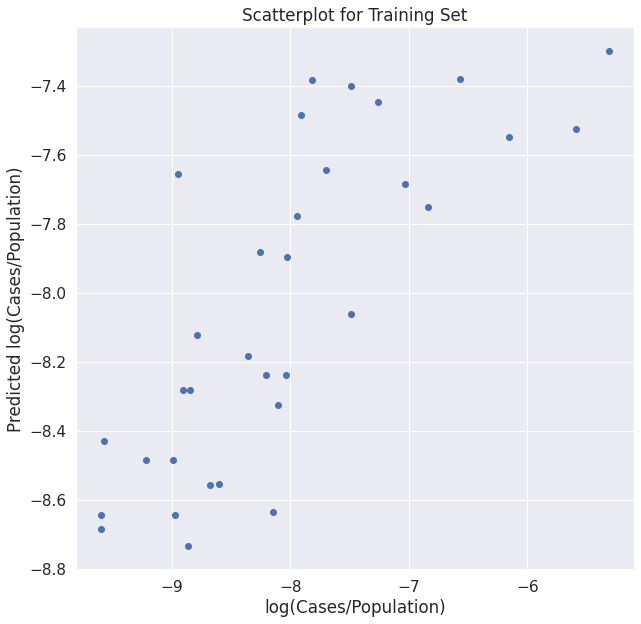

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.29344
                       R2:   -0.79570


<Figure size 432x288 with 0 Axes>

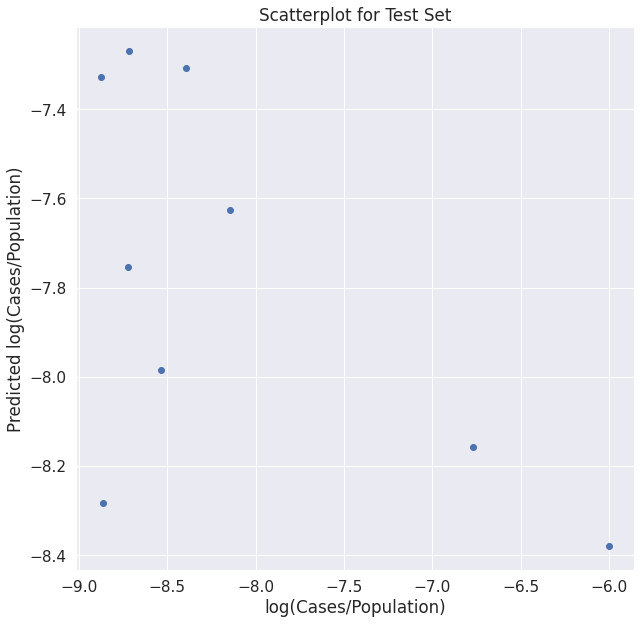

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.01470 +/- 0.04397


<Figure size 432x288 with 0 Axes>

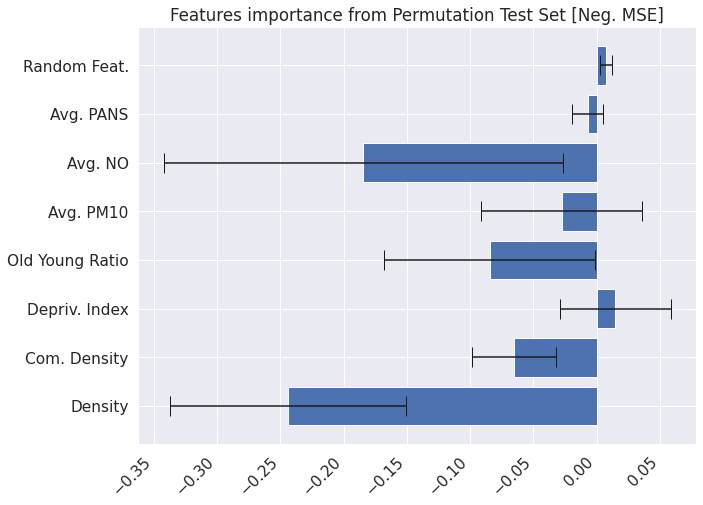

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.01578 +/- 0.04719


<Figure size 432x288 with 0 Axes>

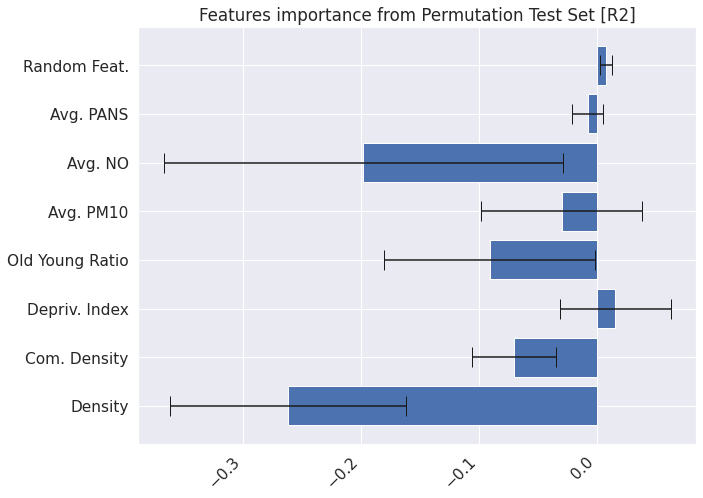

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10103 +/- 0.03926
Feature:                   Com. Density, Score: 0.02052 +/- 0.00869
Feature:                  Depriv. Index, Score: 0.05758 +/- 0.02276
Feature:                Old Young Ratio, Score: 0.09811 +/- 0.03538
Feature:                      Avg. PM10, Score: 0.05753 +/- 0.02710
Feature:                        Avg. NO, Score: 0.15594 +/- 0.05806
Feature:                      Avg. PANS, Score: 0.01889 +/- 0.00903


<Figure size 432x288 with 0 Axes>

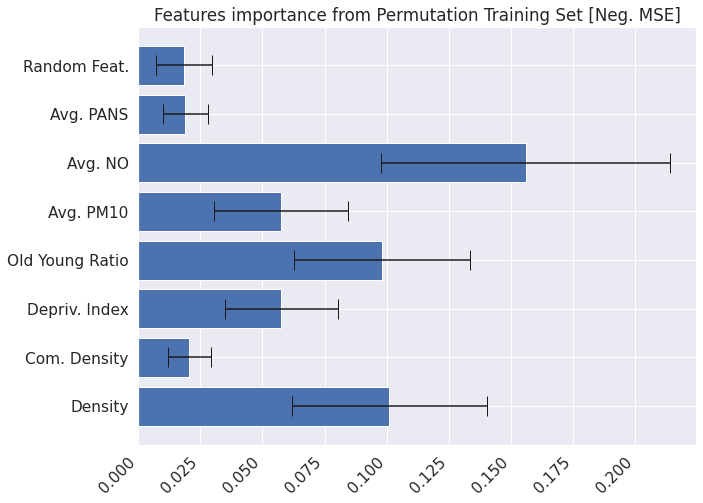

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.08827 +/- 0.03430
Feature:                   Com. Density, Score: 0.01793 +/- 0.00760
Feature:                  Depriv. Index, Score: 0.05031 +/- 0.01989
Feature:                Old Young Ratio, Score: 0.08572 +/- 0.03091
Feature:                      Avg. PM10, Score: 0.05026 +/- 0.02367
Feature:                        Avg. NO, Score: 0.13624 +/- 0.05072
Feature:                      Avg. PANS, Score: 0.01650 +/- 0.00789


<Figure size 432x288 with 0 Axes>

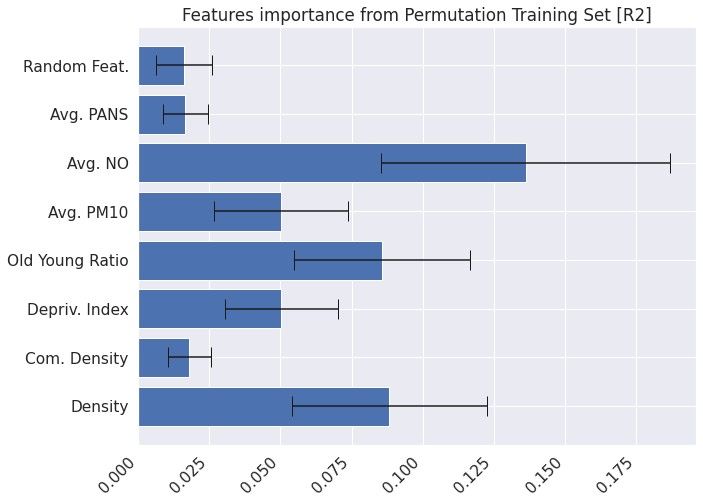

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting ...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.71077  0.09209 
    Test set average RMSE:  1.08505  0.12084 

Prediction STD :    0.48683
True value STD :    1.04859
Difference in percentage:   53.57263

             Fullset RMSE:    0.63794
                       R2:    0.62987


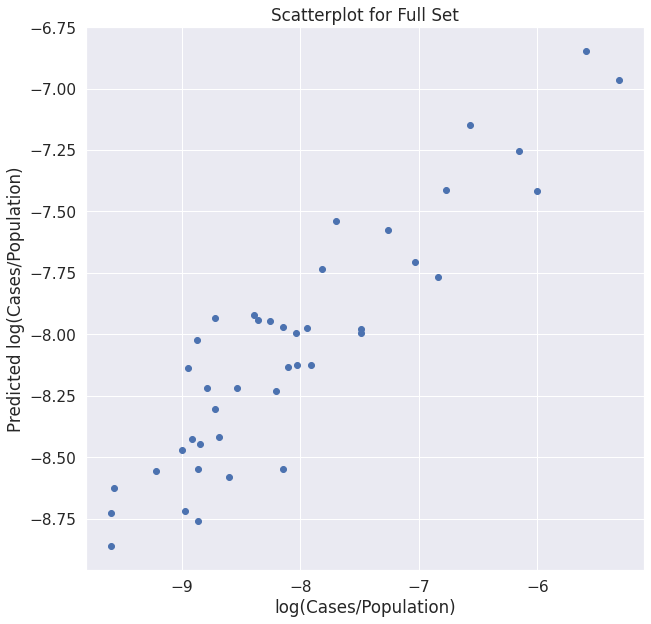

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.10016 +/- 0.02536
Feature:                Old Young Ratio, Score: 0.14422 +/- 0.03365
Feature:                      Avg. PM10, Score: 0.18977 +/- 0.03882
Feature:                        Avg. NO, Score: 0.18548 +/- 0.04923
Feature:                      Avg. PANS, Score: 0.08115 +/- 0.01650


<Figure size 432x288 with 0 Axes>

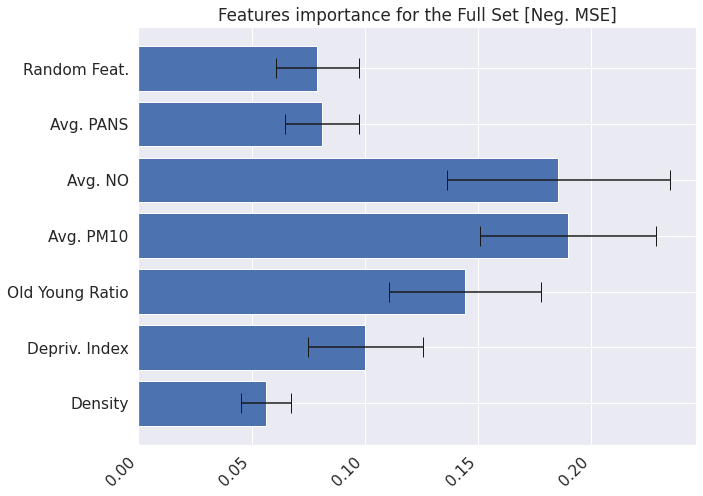

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.09109 +/- 0.02306
Feature:                Old Young Ratio, Score: 0.13117 +/- 0.03060
Feature:                      Avg. PM10, Score: 0.17259 +/- 0.03531
Feature:                        Avg. NO, Score: 0.16869 +/- 0.04477
Feature:                      Avg. PANS, Score: 0.07380 +/- 0.01501


<Figure size 432x288 with 0 Axes>

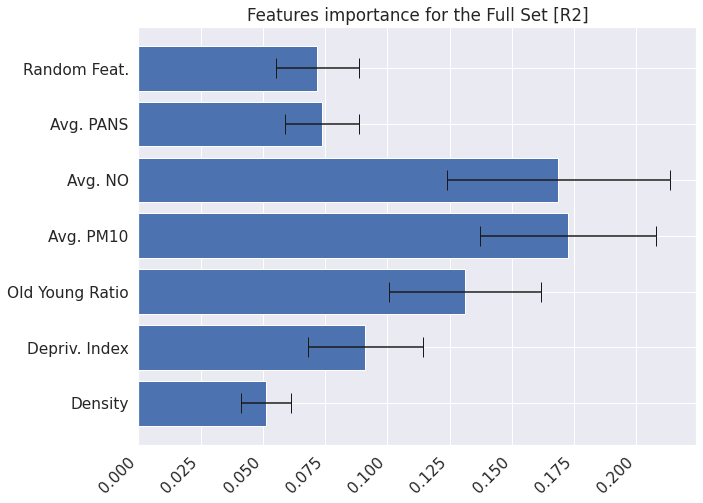

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.64958
                       R2:    0.63135


<Figure size 432x288 with 0 Axes>

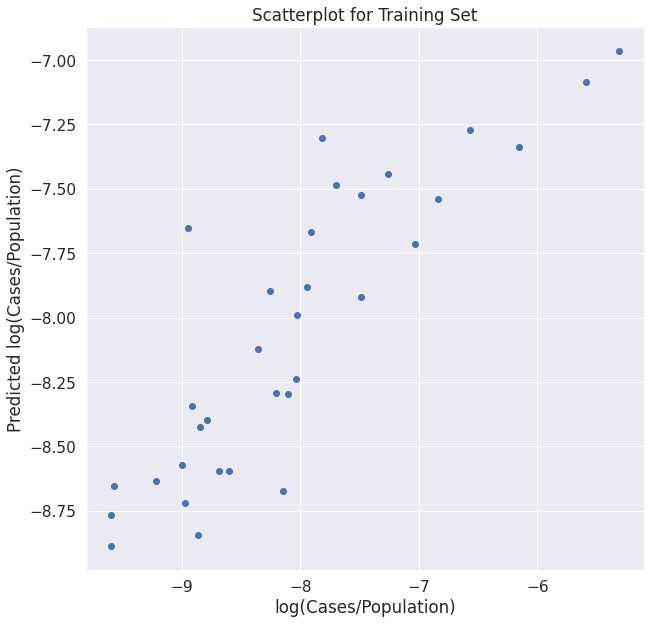

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.28105
                       R2:   -0.76145


<Figure size 432x288 with 0 Axes>

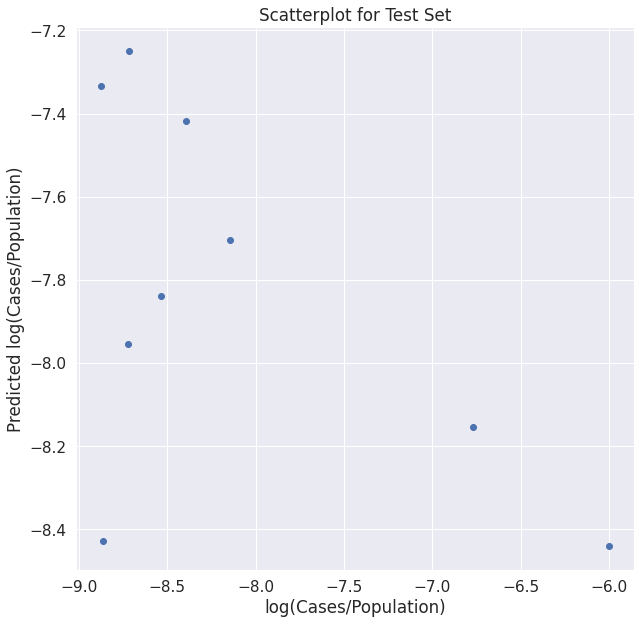

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.01921 +/- 0.05154


<Figure size 432x288 with 0 Axes>

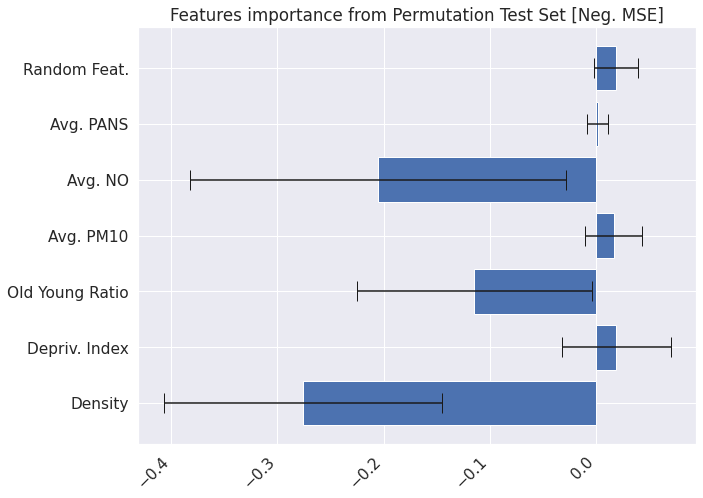

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.02062 +/- 0.05532


<Figure size 432x288 with 0 Axes>

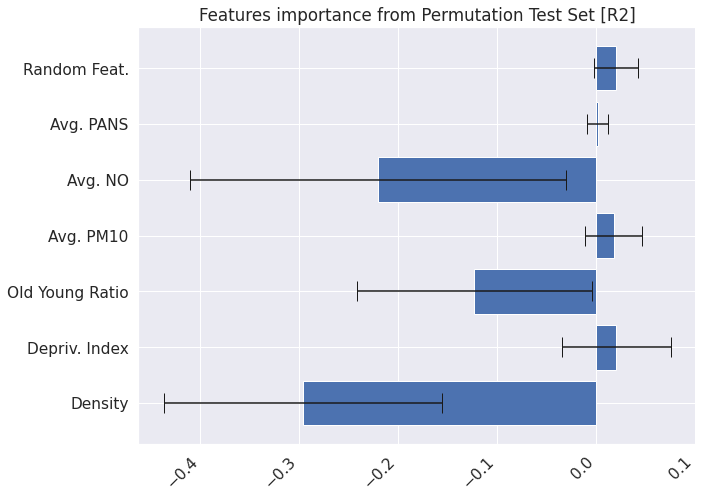

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.13960 +/- 0.04304
Feature:                  Depriv. Index, Score: 0.06895 +/- 0.02695
Feature:                Old Young Ratio, Score: 0.14513 +/- 0.04136
Feature:                      Avg. PM10, Score: 0.11622 +/- 0.02329
Feature:                        Avg. NO, Score: 0.21129 +/- 0.06915
Feature:                      Avg. PANS, Score: 0.03151 +/- 0.01091


<Figure size 432x288 with 0 Axes>

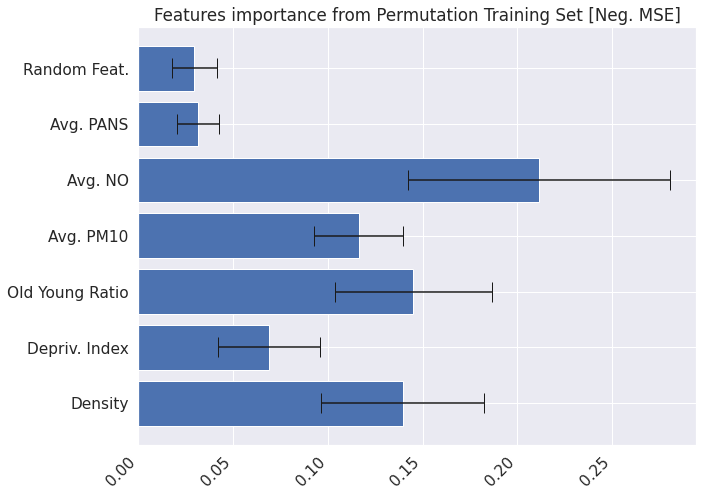

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.12196 +/- 0.03760
Feature:                  Depriv. Index, Score: 0.06024 +/- 0.02354
Feature:                Old Young Ratio, Score: 0.12680 +/- 0.03613
Feature:                      Avg. PM10, Score: 0.10154 +/- 0.02035
Feature:                        Avg. NO, Score: 0.18459 +/- 0.06042
Feature:                      Avg. PANS, Score: 0.02753 +/- 0.00953


<Figure size 432x288 with 0 Axes>

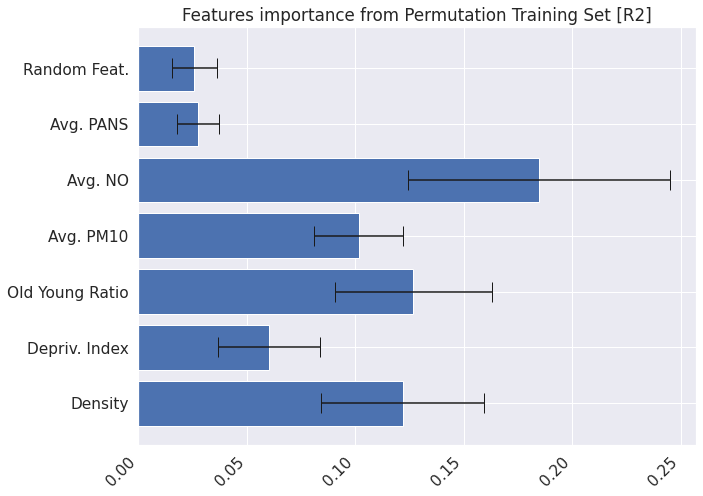

<Figure size 720x720 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [17]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}


In [18]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.38467 +/-  0.04921 
    Test set average RMSE:  1.04764 +/-  0.12017 
  Training set average R2:  0.86148 +/-  0.02072 
      Test set average R2: -0.08893 +/-  0.31373 
Taining:
             Density ,    0.08093 +/-    0.04493 ,   -0.00369 +/-    0.03345 ,    5.00000 ,    4.00000 ,    2.00000 ,    0.00000
        Com. Density ,    0.04685 +/-    0.02825 ,   -0.01422 +/-    0.03077 ,    1.00000 ,    3.00000 ,    0.00000 ,    2.00000
       Depriv. Index ,    0.10001 +/-    0.04390 ,    0.02457 +/-    0.03857 ,    5.00000 ,   15.00000 ,   10.00000 ,   17.00000
            Latitude ,    0.08389 +/-    0.03856 ,   -0.00114 +/-    0.03861 ,    1.00000 ,    7.00000 ,    1.00000 ,    5.00000
     Old Young Ratio ,    0.13541 +/-    0.07468 ,    0.02871 +/-    0.04593 ,   22.00000 ,   15.00000 ,   13.00000 ,   25.00000
           Avg. PM10 ,    0.16987 +/-    0.09151 ,    0

<Figure size 720x720 with 0 Axes>

In [19]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 1}


In [20]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.38475 +/-  0.04880 
    Test set average RMSE:  1.02747 +/-  0.12632 
  Training set average R2:  0.86494 +/-  0.02035 
      Test set average R2: -0.05686 +/-  0.20908 
Taining:
             Density ,    0.10076 +/-    0.04173 ,    0.00059 +/-    0.03797 ,    1.00000 ,    8.00000 ,    0.00000 ,    2.00000
        Com. Density ,    0.06230 +/-    0.02880 ,   -0.01929 +/-    0.03597 ,    1.00000 ,    0.00000 ,    0.00000 ,    1.00000
       Depriv. Index ,    0.11034 +/-    0.04352 ,    0.03582 +/-    0.03395 ,    5.00000 ,   12.00000 ,   13.00000 ,   19.00000
     Old Young Ratio ,    0.15272 +/-    0.05529 ,    0.02942 +/-    0.06518 ,   26.00000 ,   19.00000 ,   12.00000 ,   25.00000
           Avg. PM10 ,    0.17848 +/-    0.08339 ,    0.06825 +/-    0.05512 ,   35.00000 ,   24.00000 ,   41.00000 ,   23.00000
             Avg. NO ,    0.17103 +/-    0.07247 ,    0

<Figure size 720x720 with 0 Axes>

In [21]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...


In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)